In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from gridworld_env_assignment import GridWorld
from utils import paint_gridworld, _plot_arrows, _get_gridworld_as_array

## Checking the initial environments.
Construct a `GridWorld` with appropriate input arguments for each of the two tasks. Use `paint_gridworld` to plot the resulting environments.

In [ ]:
example_env = GridWorld(goal_locations=[(1,1)], goal_rewards=[100])

paint_gridworld(example_env)

## Example of running a simulation

In [ ]:
import time

number_of_actions = example_env.get_action_size()

reward_lst = []

# Reset the environment to start from the starting location.
# The reset() method returns the state, reward, and whether the episode is done or not
# More information can be found under the definition of the method
_, state, reward, done = example_env.reset()
reward_lst.append(reward)

# Track the most recent action from each state.
# This can make a nice visualization.
most_recent_action_from_state = np.ones(example_env.get_gridshape()) * -1
action_list = []
# Repeat until the episode is not done, i.e. the agent has not fallen into a cliff,
# the maximum length of the episode has not been exceeded, and the target has not been reached.
while not done:
    # Take a step using the step() function and passing in one of the available actions [0, 1, 2, 3]
    # corresponding to ['N', 'S', 'E', 'W']
    # More information can be found under the definition of the method
    # In this very simple example for each step we choose a random action
    action_from_state = np.random.choice(number_of_actions)

    state_as_tuple = example_env.get_loc_from_state(state)
    most_recent_action_from_state[*state_as_tuple] = action_from_state
    action_list.append((state_as_tuple, action_from_state))
    _, state, reward, done = example_env.step(action_from_state)
    reward_lst.append(reward)

print(f'Collected rewards of an episode: {reward_lst}')
grid = _get_gridworld_as_array(example_env)

fig, ax = plt.subplots(figsize=(17, 12))
ax.imshow(grid)
ax.set_xticks([])
ax.set_yticks([])

#_plot_arrows(most_recent_action_from_state, ax=ax)  # Assuming _plot_arrows accepts ax
_plot_arrows_2(action_list[:5], ax)
plt.pause(0.01)
_plot_arrows_2(action_list[:10], ax)
fig.canvas.draw()
plt.show()

# Create an RL Agent

Implement either SARSA or Q-learning to determine how your agent executes actions and learns from the gathered rewards.

In [ ]:
def learn_policy_sarsa_lambda(env: GridWorld, 
                              n_episodes: int=1, 
                              eta=0.1, 
                              gamma=0.1, 
                              epsilon_start=0.1,
                              epsilon_decay=100000,
                              lambda_ = 1
                      ) -> tuple[np.ndarray, list[float], list[int]]:
    """
    Solve a given GridWorld environment using SARSA or Q-learning

    Args:
        env: The grid-world environment that will return states and rewards when given actions.
        n_episodes: Number of episodes for which to run learning.

    Returns:
        policy: A 2D array that represents the best action to take from each state location.
        total_rewards: Corresponding list of successive total non-discounted sum of reward for each trial
        episode_lengths: Corresponding list of episode lengths.
    """
    feedback_steps = 25
    
    Q = np.ones((env.get_state_size(), 4)) * 0.1
    total_rewards = []
    episode_lengths = []
    most_recent_action_from_state = np.ones(env.get_gridshape()) * -1
    then = time.time()
    for episode in range(n_episodes):
        if (episode % feedback_steps == 0):
            now = time.time()
            dt = now - then
            remaining = (n_episodes - episode)
            speed = feedback_steps / dt
            est = remaining / speed
            print(f"{episode} | {np.trunc(est)}s left ({remaining} steps) | [ {speed} steps / s ]")
            then = time.time()
        e = np.ones((env.get_state_size(), 4)) * 0
        greedy_actions = np.ones(env.get_gridshape())
        _, state, reward, done = env.reset()
        action = epsilon_greedy_safe(state, Q, epsilon_start)
        total_rewards.append(0)
        episode_lengths.append(0)
        while not done:
            _, new_state, reward, done = env.step(action)
            epsilon = epsilon_f(_, epsilon_start, epsilon_decay)
            loc = env.get_loc_from_state(new_state)
            total_rewards[episode] += reward
            episode_lengths[episode] += 1
            state_as_tuple = env.get_loc_from_state(state)
            most_recent_action_from_state[*state_as_tuple] = action
            new_action = epsilon_greedy_safe(new_state, Q, epsilon)
            if (done):
                delta = reward - Q[state][action]
            else:
                delta = reward + gamma*Q[new_state][new_action] - Q[state][action]
            e[state][action] += 1
            for state in range(len(Q)):
                for action in range(4):
                    Q[state][action] += eta * delta * e[state][action]
                    e[state][action] *= gamma * lambda_
            state = new_state
            action = new_action
    for state in range(len(Q)):
        i,j = env.get_loc_from_state(state)

        greedy_actions[i][j] = epsilon_greedy_safe(state, Q, -1, True) if most_recent_action_from_state[i][j] != -1 else -1
    #paint_gridworld(env, actions=greedy_actions)

    policy = greedy_actions


    return policy, total_rewards, episode_lengths, Q


In [ ]:
def epsilon_greedy(state, Q, epsilon, deterministic = False):
    if np.random.random() < epsilon:
      # explore randomly
      return np.random.randint(0, 4)
    else:
      # take greedy action
      best_reward = np.max(Q[state])
      best_actions = np.flatnonzero(Q[state] == best_reward)
      if deterministic:
        return best_actions[0]
      return np.random.choice(best_actions)

def epsilon_greedy_safe(state, Q, epsilon, deterministic = False): # Only takes negative random option if absolutely necessary
    if np.random.random() < epsilon:
        # explore randomly, safely
        values = Q[state]
        if np.max(values) < 0:
            return np.random.randint(0, 4)
        safe_actions = np.flatnonzero(values >= 0)
        return np.random.choice(safe_actions)
    else:
        # take greedy action
        best_reward = np.max(Q[state])
        best_actions = np.flatnonzero(Q[state] == best_reward)
        if deterministic:
            return best_actions[0]
        return np.random.choice(best_actions)

def epsilon_greedy_safe_noback(state, banned_action, Q, epsilon, deterministic = False): # Only takes negative random option if absolutely necessary
    if np.random.random() < epsilon:
        # explore randomly, safely
        values = Q[state]
        if np.max(values) < 0:
            return np.random.randint(0, 4)
        safe_actions = np.flatnonzero(values >= 0)
        safe_actions = safe_actions[safe_actions != state]
        if len(safe_actions) == 0:
            return np.random.randint(0, 4)
        return np.random.choice(safe_actions)
    else:
        # take greedy action
        values = np.copy(Q[state])
        values[banned_action] = -100000
        best_reward = np.max(values)
        best_actions = np.flatnonzero(Q[state] == best_reward)
        
        if deterministic:
            return best_actions[0]
        return np.random.choice(best_actions)


def epsilon_f_1(_, start, decay_time):
    return start * (decay_time - _) / decay_time

def epsilon_f_2(_, stage_2_time, stage_2_rate):
    return 1 if _ < stage_2_time else stage_2_rate


def max_steps_f(_): pass

def learn_policy_sarsa(env: GridWorld, 
                       n_episodes: int=1, 
                       eta=0.1, 
                       gamma=0.1, 
                       epsilon_start=0.1,
                       epsilon_decay=100000
                      ) -> tuple[np.ndarray, list[float], list[int]]:
    """
    Solve a given GridWorld environment using SARSA or Q-learning

    Args:
        env: The grid-world environment that will return states and rewards when given actions.
        n_episodes: Number of episodes for which to run learning.

    Returns:
        policy: A 2D array that represents the best action to take from each state location.
        total_rewards: Corresponding list of successive total non-discounted sum of reward for each trial
        episode_lengths: Corresponding list of episode lengths.
    """

    ####
    # Add your code here
    # WARNING: this agent should only access env.reset() and env.step()
    ####
    debug = 0
    feedback_steps = 100
    epsilon_f = epsilon_f_2
    Q = np.ones((env.get_state_size(), 4)) * 0.1
    total_rewards = []
    episode_lengths = []
    most_recent_action_from_state = np.ones(env.get_gridshape()) * -1
    then = time.time()
    start_time = then
    for episode in range(n_episodes):
        if (episode % feedback_steps == 0):
            now = time.time()
            dt = now - then
            remaining = (n_episodes - episode)
            speed = feedback_steps / dt
            est = remaining / speed
            print(f"{episode} | {np.trunc(est)}s left ({remaining} steps) | [ {np.trunc(100*speed)/100} steps / s ]      [{np.trunc(now - start_time)}s]")
            then = time.time()
        greedy_actions = np.ones(env.get_gridshape())
        _, state, reward, done = env.reset()
        action = epsilon_greedy_safe(state, Q, epsilon_start)
        total_rewards.append(0)
        episode_lengths.append(0)
        while not done:
            _, new_state, reward, done = env.step(action)
            epsilon = epsilon_f(episode, epsilon_start, epsilon_decay)
            if  _ % 25 == 0 and debug < 0:
                print(epsilon, _)
                debug += 1
            banned_action = (action + 2) % 4
            
            total_rewards[episode] += reward
            episode_lengths[episode] += 1
            state_as_tuple = env.get_loc_from_state(state)
            most_recent_action_from_state[*state_as_tuple] = action
            new_action = epsilon_greedy_safe_noback(new_state, banned_action, Q, epsilon)
            if (done):
                delta = reward - Q[state][action]
            else:
                delta = reward + gamma*Q[new_state][new_action] - Q[state][action]
            Q[state][action] += eta * delta
            state = new_state
            action = new_action
    for state in range(len(Q)):
        i,j = env.get_loc_from_state(state)
        greedy_actions[i][j] = epsilon_greedy_safe(state, Q, -1, True) if most_recent_action_from_state[i][j] != -1 else -1
    

    policy = greedy_actions




    return policy, total_rewards, episode_lengths, Q





# Learn Policy for Dual Targets with Differing Rewards
Learn a policy for an environment with two goals, where the more distant goal is considerably more valuable.

TIP: Test the learning algorithm with an environment that has just a single reward, and in different positions.

TIP: Modify the relative rewards between the two goals to see changes in behavior.

In [ ]:
import time

env = GridWorld(goal_locations=[(1,2), (8, 11)], goal_rewards=[5000, 250])


# Example of running agent
then = time.time()
policy, total_rewards, total_steps, Q = learn_policy_sarsa(env,
                                                      n_episodes = 5000,
                                                      eta= 0.5,
                                                      gamma = 1 - 0.01,
                                                      epsilon_start= 1500,
                                                      epsilon_decay = 0  
                                                       )
now = time.time()
print(f"{now - then} seconds")
# Plotting
draw_grid_Q_arrows(env, Q)
draw_grid_text(env, Q)
paint_gridworld(env, actions=policy)
plot_rewards_and_steps(total_rewards, total_steps)
values, counts = np.unique(total_rewards, return_counts=True)
rewards_occurences = dict(zip(values, counts))
values, counts = np.unique(total_steps, return_counts=True)
steps_occurences = dict(zip(values, counts))
print("Rewards:", rewards_occurences)

In [ ]:
import time

times = []

env = GridWorld(goal_locations=[(1,2), (8, 11)], goal_rewards=[5000, 250])

num_episodes_array = []
num_trials = 20
min_ep = 100
max_ep = 600

for i in range(num_trials):
    num_episodes_array.append(np.random.randint(min_ep, max_ep))

for num_episodes in num_episodes_array:
    then = time.time()
    policy, total_rewards, total_steps, Q = learn_policy_sarsa_lambda(env,
                                                          n_episodes = num_episodes,
                                                          eta= 0.95,
                                                          gamma = 1 - 0.2,
                                                          epsilon_start= 1,
                                                          epsilon_decay = 1000  
                                                           )
    now = time.time()
    times.append((num_episodes, now-then))
    print(f"{num_episodes} episodes took {now-then} seconds")

plt.plot(num_episodes_array, times)

In [ ]:
times1 = [t[1] for t in times]

plt.scatter(num_episodes_array, times1)

In [ ]:
def _plot_arrows(actions: np.ndarray, ax, arrow_size: float = 0.3):
    """
    Plots arrows on the given Axes object based on the provided actions.

    Assumes a mapping of 0 (North), 1 (East), 2 (South), 3 (West).
    """
    shape = actions.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            action = actions[i, j]
            if action == 2:  # Up
                dx, dy = 0, arrow_size
            elif action == 1:  # Right
                dx, dy = arrow_size, 0
            elif action == 0:  # Down
                dx, dy = 0, -arrow_size
            elif action == 3:  # Left
                dx, dy = -arrow_size, 0
            else:
                continue  # No action or invalid action

            ax.arrow(j, i, dx, dy,
                     head_width=0.2,
                     head_length=0.2,
                     fc='black', ec='black')

            ax.text(j, i, f'{action}', color='red', ha='center', va='center', fontsize=12)

def _plot_arrows_2(actions, ax, arrow_size: float = 0.3):
    """
    Plots arrows on the given Axes object based on the provided actions.

    Assumes a mapping of 0 (North), 1 (East), 2 (South), 3 (West).
    """

    for index in range(len(actions)):
        action = actions[index][1]
        loc = actions[index][0]
        i = loc[0]
        j = loc[1]
        if action == 2:  # Up
            dx, dy = 0, arrow_size
        elif action == 1:  # Right
            dx, dy = arrow_size, 0
        elif action == 0:  # Down
            dx, dy = 0, -arrow_size
        elif action == 3:  # Left
            dx, dy = -arrow_size, 0
        else:
            continue  # No action or invalid action

        ax.arrow(j, i, dx, dy,
                  head_width=0.2,
                  head_length=0.2,
                  fc='black', ec='black')

        ax.text(j, i, f'{index}', color='red', ha='center', va='center', fontsize=12)

def plot_text(text):
    shape = text.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            action = actions[i, j]

            ax.arrow(j, i, dx, dy,
                     head_width=0.2,
                     head_length=0.2,
                     fc='black', ec='black')

            ax.text(j, i, f'{action}', color='red', ha='center', va='center', fontsize=12)


def draw_grid_text(env, Q):
    grid = _get_gridworld_as_array(env)
    plt.figure(figsize=(17, 12))
    plt.imshow(grid)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    for state in range(len(Q)):
        i,j = env.get_loc_from_state(state)
        qvs = Q[state]
        qstr = ""
        n = 0
        for v in qvs:
            v = np.trunc(v * 10) / 10
            qstr += f"{v} "
            if n%2:
                qstr+="\n"
            n+=1
        plt.text(j-0.35, i+0.25, qstr)
        
    plt.show()        

def draw_grid_Q_arrows(env, Q):
    max_len = 0.25
    q_values = np.sort(np.ravel(Q))
    neg = q_values[q_values < 0]
    non_neg = q_values[q_values >= 0]
    centile = 1
    _75cent_pos = non_neg[int( len(non_neg)*centile ) - 1]
    _75cent_neg = neg[int( len(neg)*centile ) - 1]
    
    arrow_scale_pos = _75cent_pos / max_len
    arrow_scale_neg = _75cent_neg / max_len
    grid = _get_gridworld_as_array(env)
    plt.figure(figsize=(17, 12))
    plt.imshow(grid)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    print(arrow_scale_pos, arrow_scale_neg)
    print(f"len(neg): {len(neg)}, neg[-1]: {neg[-1]}")
    for state in range(len(Q)):
        i,j = env.get_loc_from_state(state)
        qvs = Q[state]
        for a in range(len(qvs)):
            v = qvs[a]
            arrow_scale = arrow_scale_pos if v >= 0 else -arrow_scale_neg
            #v = 10*v if np.abs(v) > 10 else 0 
            if a == 2:  # Up
                dx, dy = 0, np.min([max_len, np.abs(v) / arrow_scale]),
            elif a == 1:  # Right
                dx, dy = np.min([max_len, np.abs(v) / arrow_scale]), 0
            elif a == 0:  # Down
                dx, dy = 0, -np.min([max_len, np.abs(v) / arrow_scale])
            elif a == 3:  # Left
                dx, dy = -np.min([max_len, np.abs(v) / arrow_scale]), 0

            c = "green" if v > 0 else "red"
            plt.arrow(j, i, dx, dy,
         head_width=np.min([0.2, np.abs(v) / arrow_scale]),
         head_length=np.min([0.2, np.abs(v) / arrow_scale]),
         fc=c, ec=c)
    # You should use these outputs to plot graphs
    plt.show()

def plot_rewards_and_steps(total_rewards, total_steps, fn=None):
    num_bins = 50
    l = len(total_rewards)
    r = l % num_bins
    bin_size = int((l-r)/num_bins)
    total_rewards = total_rewards[:l-r]
    total_steps = total_steps[:l-r]
    rewards_avg = np.mean(np.array(total_rewards).reshape(-1, bin_size), axis=1)
    steps_avg = np.mean(np.array(total_steps).reshape(-1, bin_size), axis=1)
    episodes_bins = np.arange(len(rewards_avg))
    episodes = np.arange(len(total_rewards))
    fig, ax1 = plt.subplots()
    
    color = 'tab:blue'
    ax1.set_xlabel(f'Episodes (group size {bin_size})')
    ax1.set_ylabel('Average Reward', color=color)
    ax1.plot(episodes_bins, rewards_avg, label='Rewards', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Average Steps', color=color)
    ax2.plot(episodes_bins, steps_avg, label='Steps', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(bottom=0, top = np.max(steps_avg) + 100)
    
    plt.title('SARSA Performance Averaged')
    fig.tight_layout()
    plt.show()
    
    # Plot rewards
    plt.figure()
    color = 'tab:blue'
    plt.xlabel(f'Episodes (group size {bin_size})')
    plt.ylabel('Reward', color=color)
    plt.plot(episodes, total_rewards, label='Rewards', color=color)
    plt.tick_params(axis='y', labelcolor=color)
    plt.title('SARSA Rewards')
    plt.show()
    
    # Plot steps
    plt.figure()
    color = 'tab:orange'
    plt.xlabel(f'Episodes (group size {bin_size})')
    plt.ylabel('Steps', color=color)
    plt.plot(episodes, total_steps, label='Steps', color=color)
    plt.tick_params(axis='y', labelcolor=color)
    plt.ylim(bottom=0, top=np.max(steps_avg) + 100)
    plt.title('SARSA Steps')
    plt.show()


0 | 0.0s left (5000 steps) | [ 59918628.57 steps / s ]      [0.0s]
100 | 11.0s left (4900 steps) | [ 440.08 steps / s ]      [0.0s]
200 | 5.0s left (4800 steps) | [ 915.89 steps / s ]      [0.0s]
300 | 4.0s left (4700 steps) | [ 1169.9 steps / s ]      [0.0s]
400 | 6.0s left (4600 steps) | [ 706.08 steps / s ]      [0.0s]
500 | 4.0s left (4500 steps) | [ 927.94 steps / s ]      [0.0s]
600 | 6.0s left (4400 steps) | [ 714.64 steps / s ]      [0.0s]
700 | 6.0s left (4300 steps) | [ 714.87 steps / s ]      [0.0s]
800 | 4.0s left (4200 steps) | [ 934.7 steps / s ]      [1.0s]
900 | 3.0s left (4100 steps) | [ 1089.38 steps / s ]      [1.0s]
1000 | 4.0s left (4000 steps) | [ 814.59 steps / s ]      [1.0s]
1100 | 3.0s left (3900 steps) | [ 982.08 steps / s ]      [1.0s]
1200 | 3.0s left (3800 steps) | [ 1137.86 steps / s ]      [1.0s]
1300 | 5.0s left (3700 steps) | [ 708.35 steps / s ]      [1.0s]
1400 | 3.0s left (3600 steps) | [ 1087.66 steps / s ]      [1.0s]
1500 | 5.0s left (3500 steps)

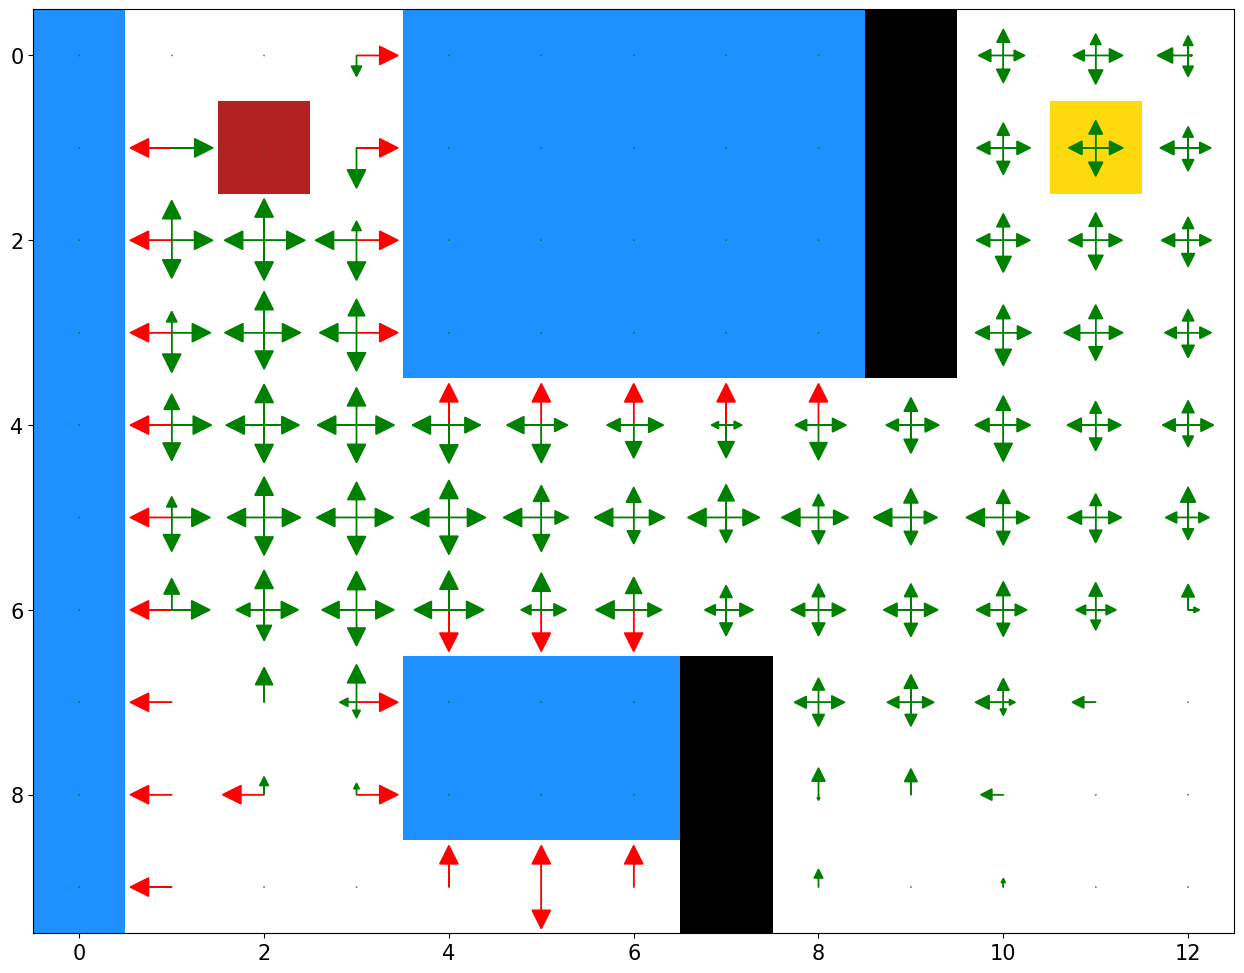

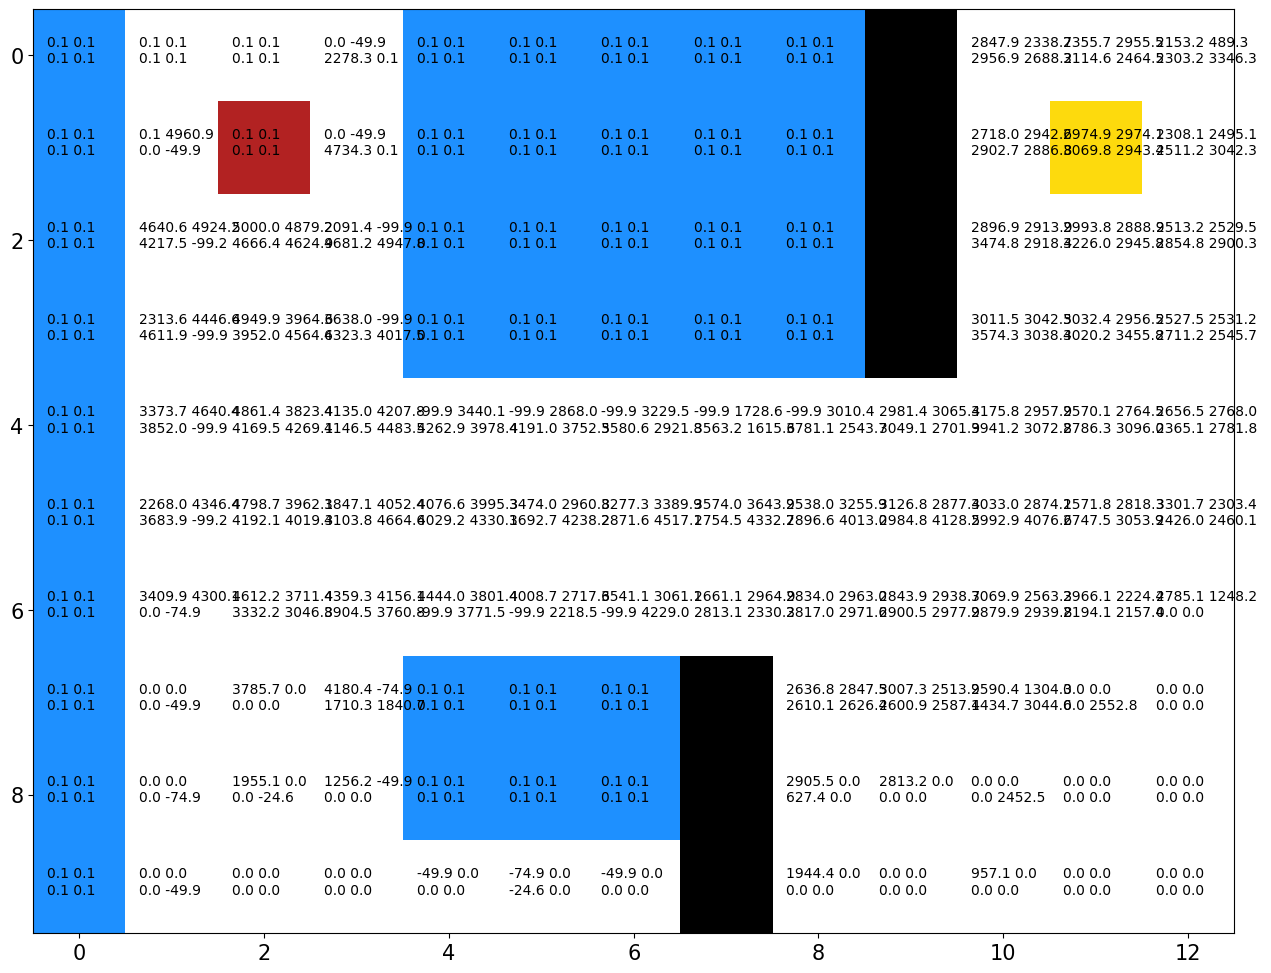

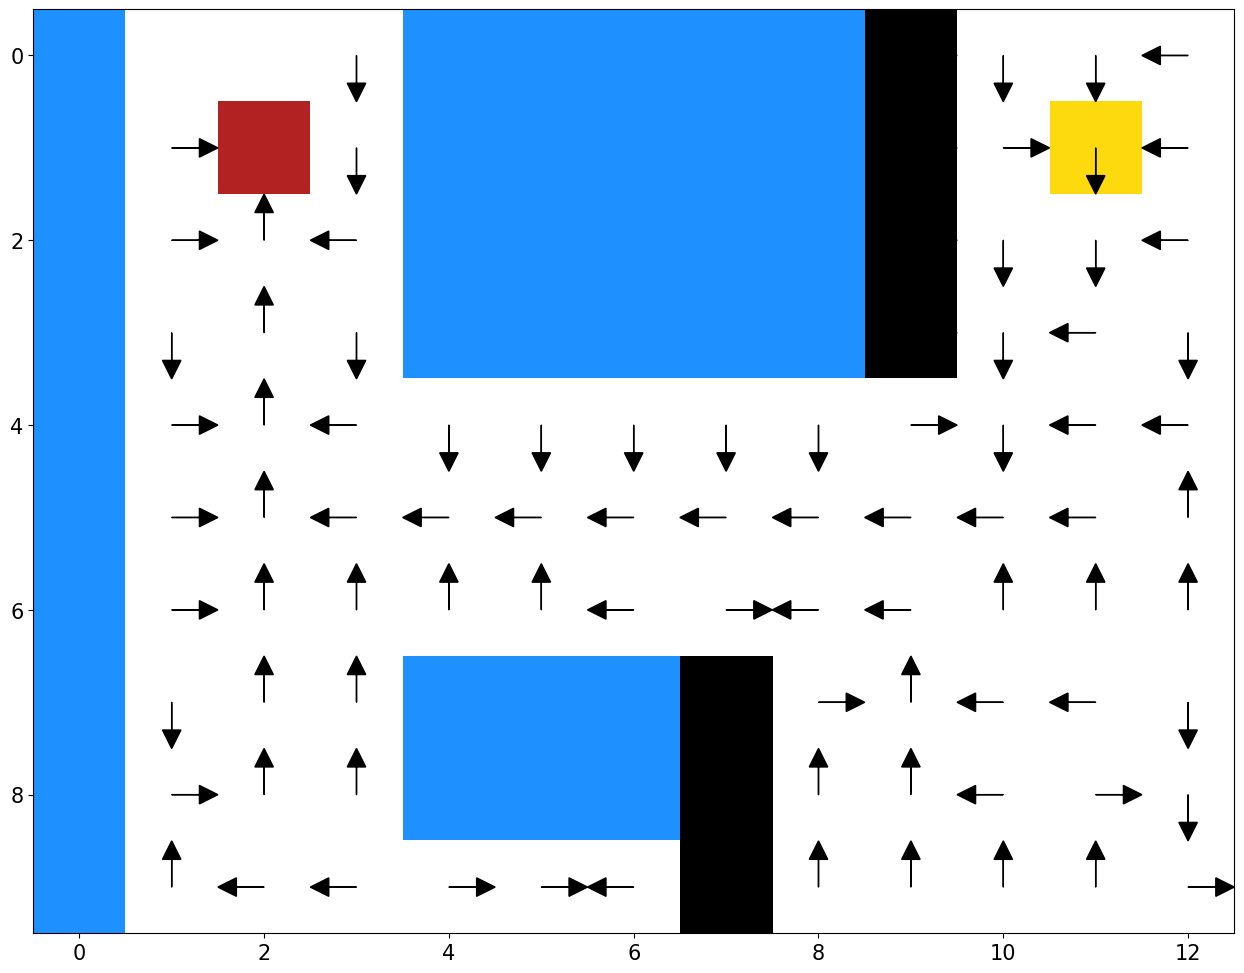

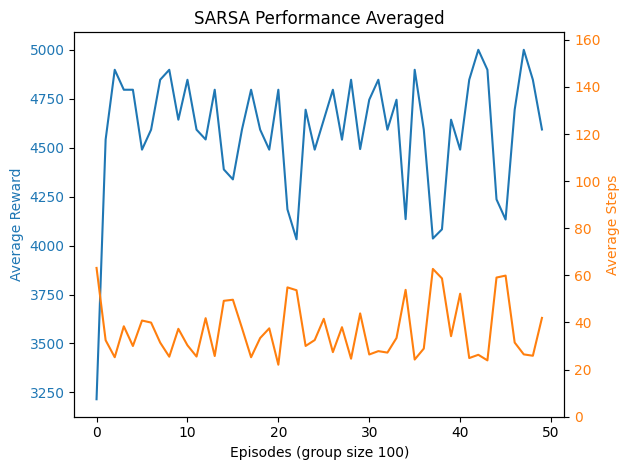

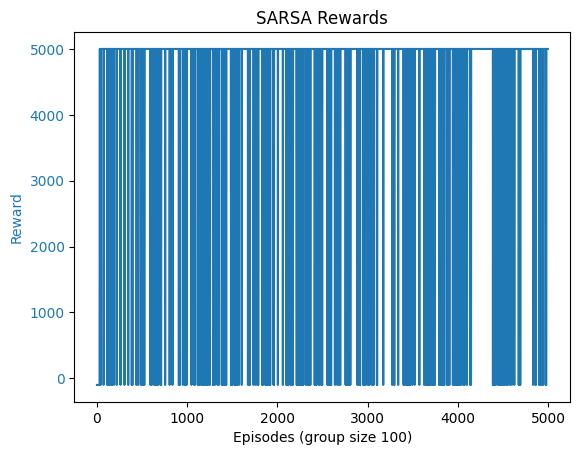

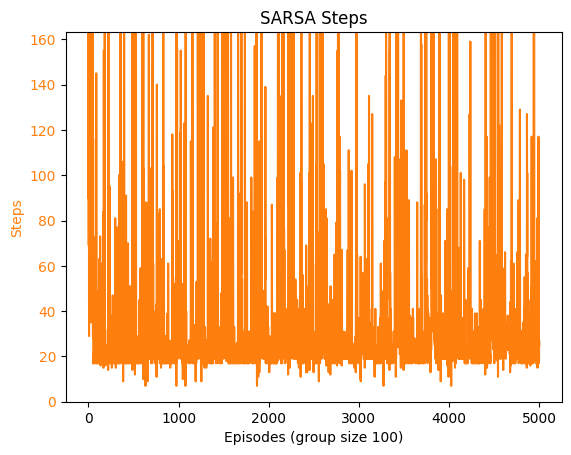

Rewards:
-100.0 387
0.0 20
5000.0 4593
0 | 0.0s left (5000 steps) | [ 69905066.66 steps / s ]      [0.0s]
100 | 2.0s left (4900 steps) | [ 1743.07 steps / s ]      [0.0s]
200 | 3.0s left (4800 steps) | [ 1435.86 steps / s ]      [0.0s]
300 | 3.0s left (4700 steps) | [ 1202.48 steps / s ]      [0.0s]
400 | 3.0s left (4600 steps) | [ 1185.28 steps / s ]      [0.0s]
500 | 1.0s left (4500 steps) | [ 2401.57 steps / s ]      [0.0s]
600 | 3.0s left (4400 steps) | [ 1317.89 steps / s ]      [0.0s]
700 | 2.0s left (4300 steps) | [ 1783.99 steps / s ]      [0.0s]
800 | 2.0s left (4200 steps) | [ 1589.63 steps / s ]      [0.0s]
900 | 1.0s left (4100 steps) | [ 2501.04 steps / s ]      [0.0s]
1000 | 1.0s left (4000 steps) | [ 2067.62 steps / s ]      [0.0s]
1100 | 1.0s left (3900 steps) | [ 2332.46 steps / s ]      [0.0s]
1200 | 1.0s left (3800 steps) | [ 2706.68 steps / s ]      [0.0s]
1300 | 1.0s left (3700 steps) | [ 2509.74 steps / s ]      [0.0s]
1400 | 1.0s left (3600 steps) | [ 2482.14 ste

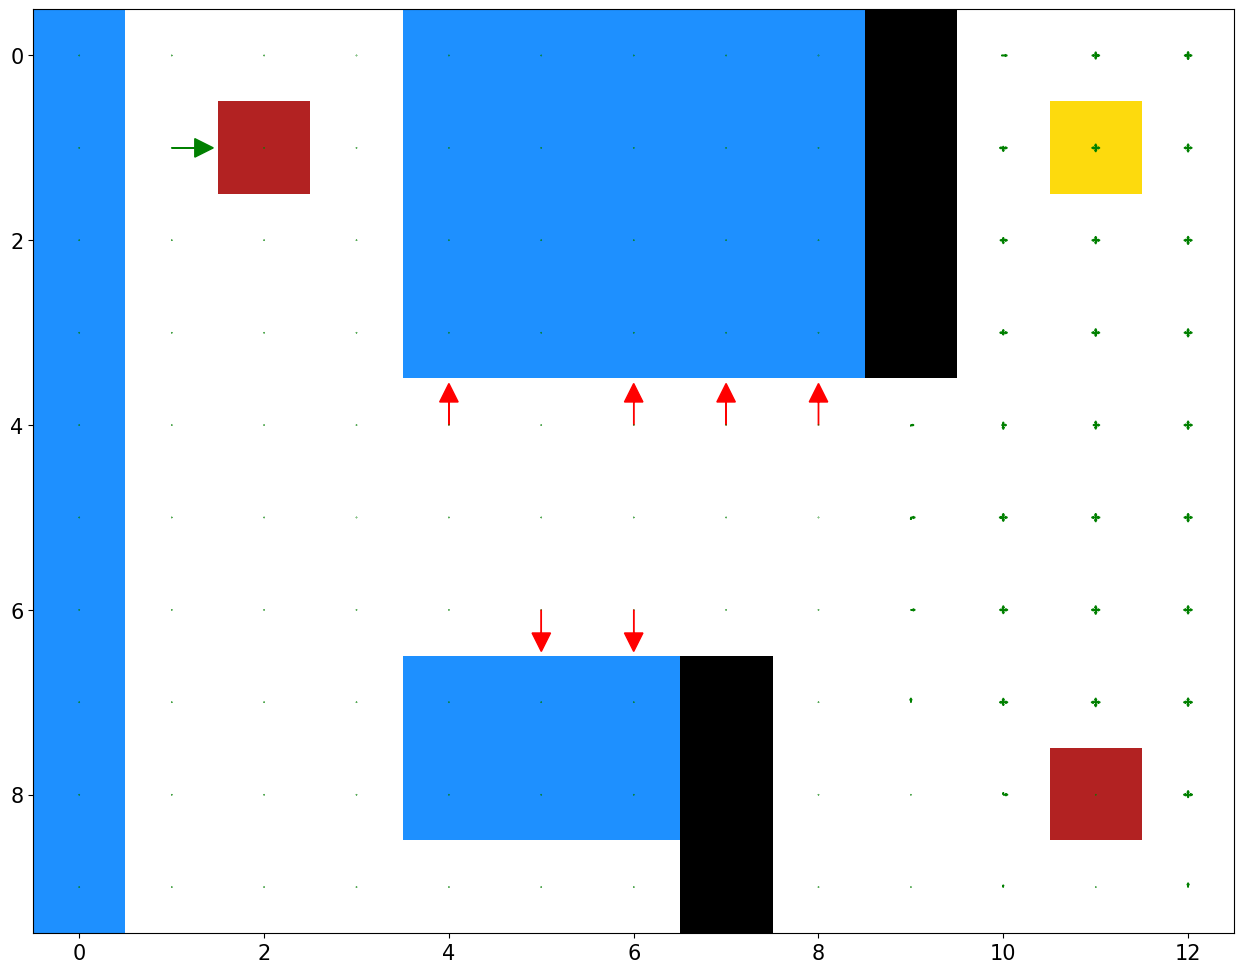

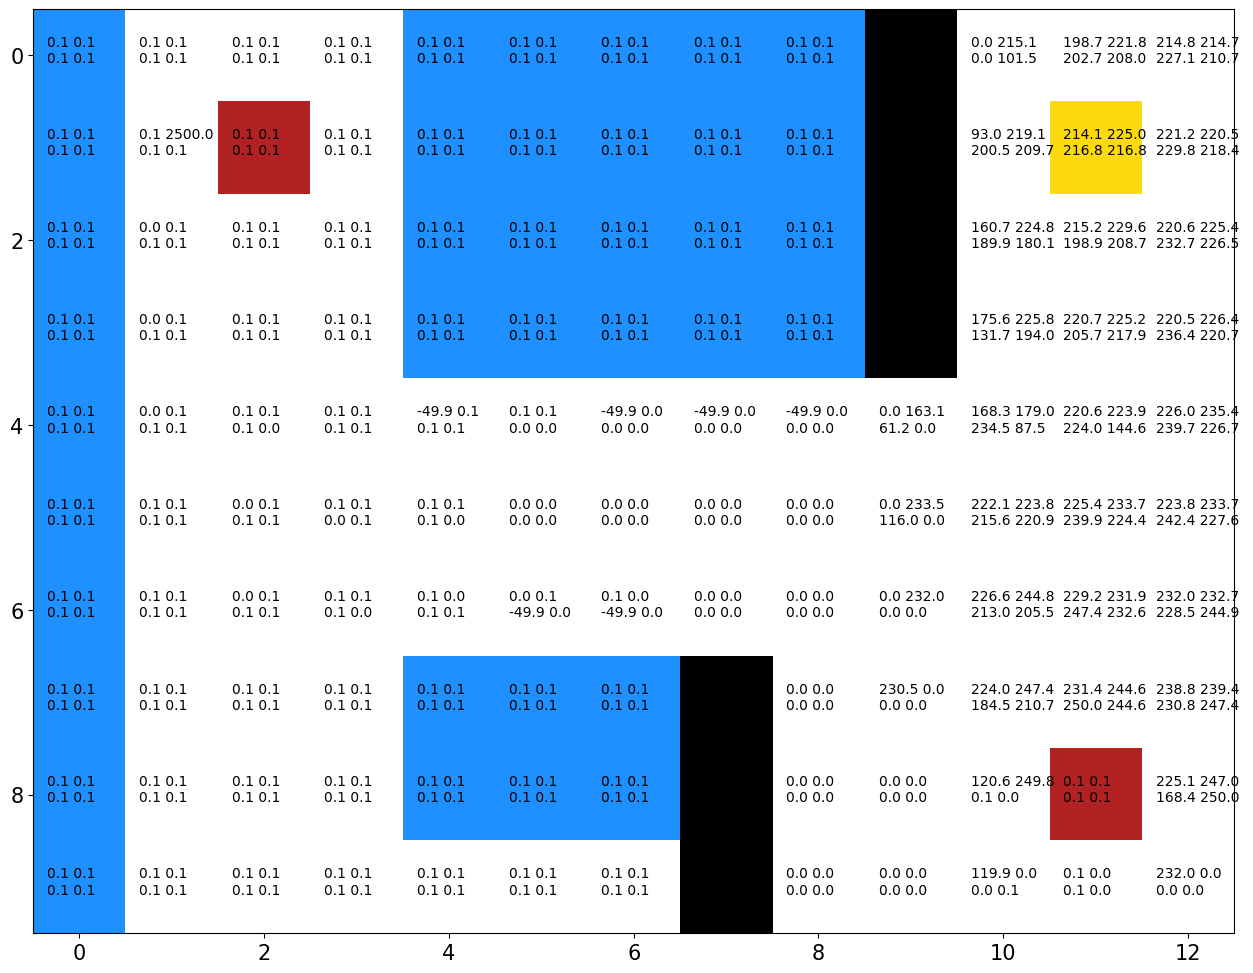

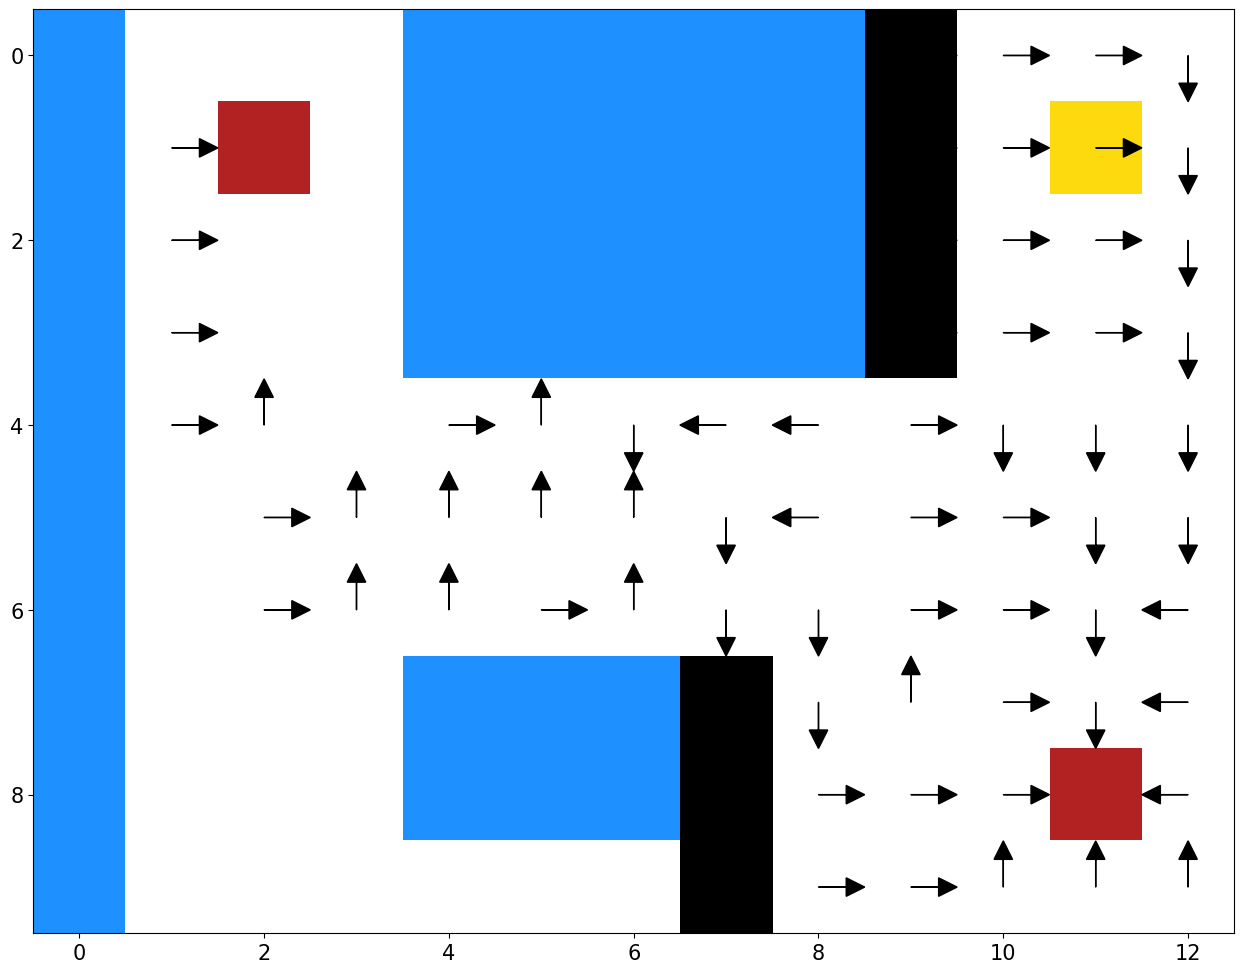

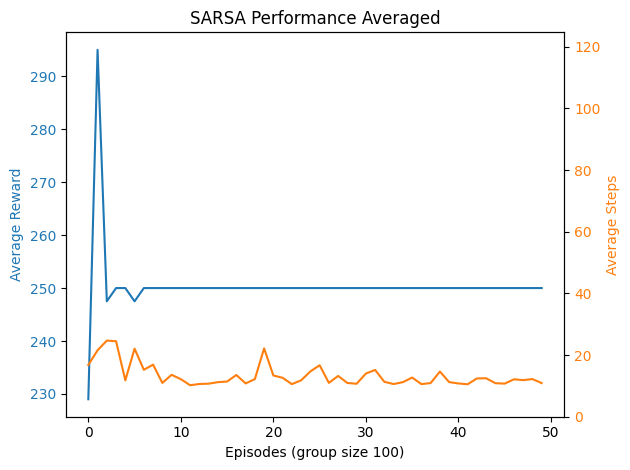

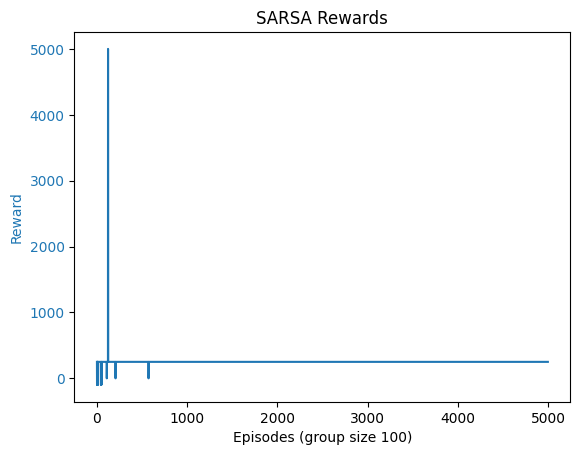

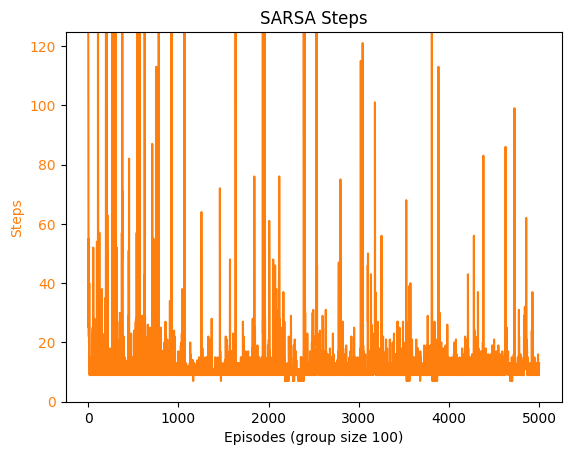

Rewards:
-100.0 6
0.0 3
250.0 4990
5000.0 1
0 | 0.0s left (5000 steps) | [ 83886080.0 steps / s ]      [0.0s]
100 | 3.0s left (4900 steps) | [ 1278.46 steps / s ]      [0.0s]
200 | 3.0s left (4800 steps) | [ 1549.19 steps / s ]      [0.0s]
300 | 3.0s left (4700 steps) | [ 1508.36 steps / s ]      [0.0s]
400 | 3.0s left (4600 steps) | [ 1308.29 steps / s ]      [0.0s]
500 | 3.0s left (4500 steps) | [ 1382.48 steps / s ]      [0.0s]
600 | 2.0s left (4400 steps) | [ 1698.66 steps / s ]      [0.0s]
700 | 2.0s left (4300 steps) | [ 1575.69 steps / s ]      [0.0s]
800 | 2.0s left (4200 steps) | [ 1765.58 steps / s ]      [0.0s]
900 | 2.0s left (4100 steps) | [ 1769.74 steps / s ]      [0.0s]
1000 | 2.0s left (4000 steps) | [ 1553.95 steps / s ]      [0.0s]
1100 | 2.0s left (3900 steps) | [ 1616.64 steps / s ]      [0.0s]
1200 | 2.0s left (3800 steps) | [ 1633.09 steps / s ]      [0.0s]
1300 | 2.0s left (3700 steps) | [ 1757.11 steps / s ]      [0.0s]
1400 | 1.0s left (3600 steps) | [ 1829.62

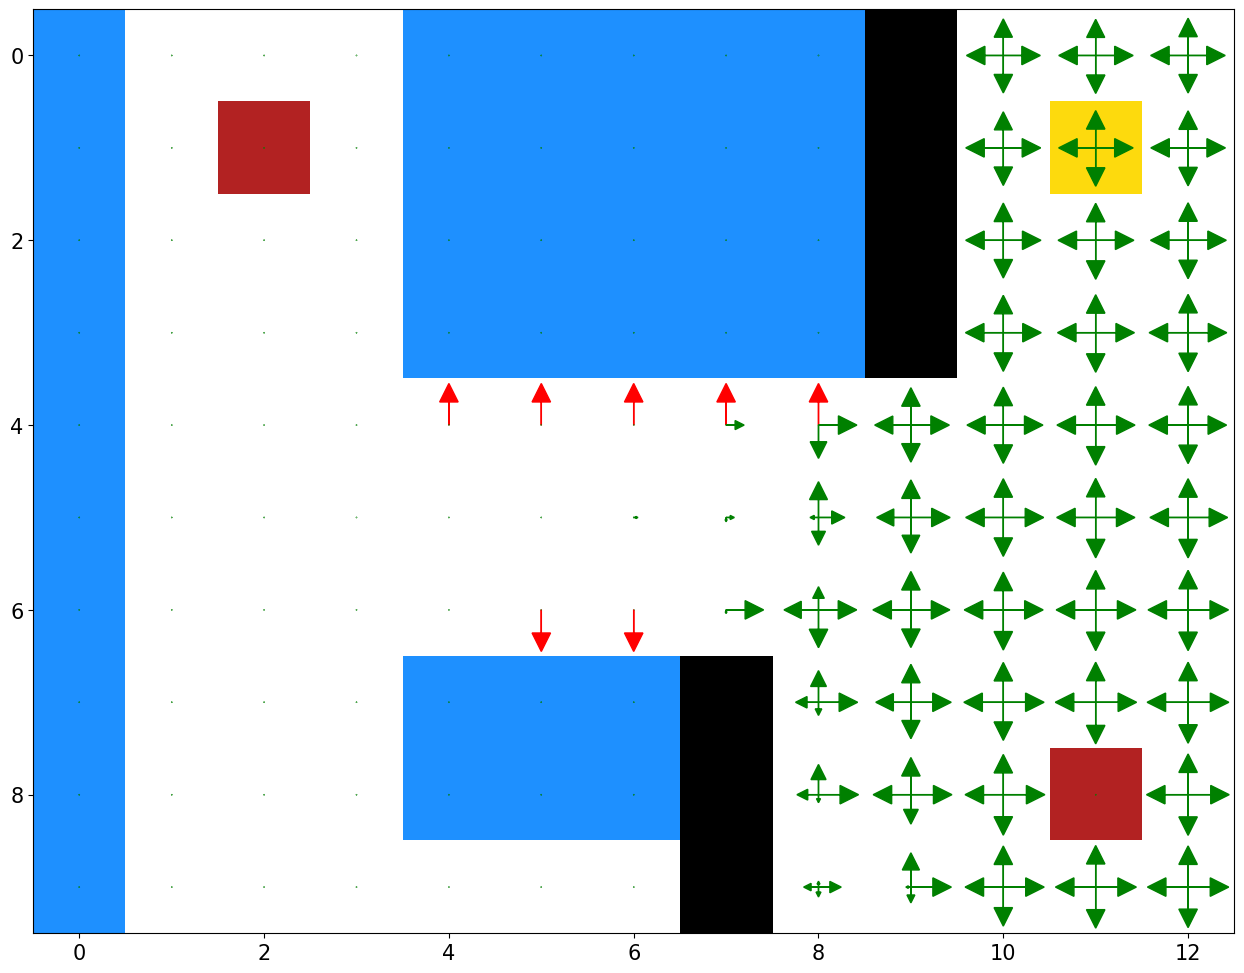

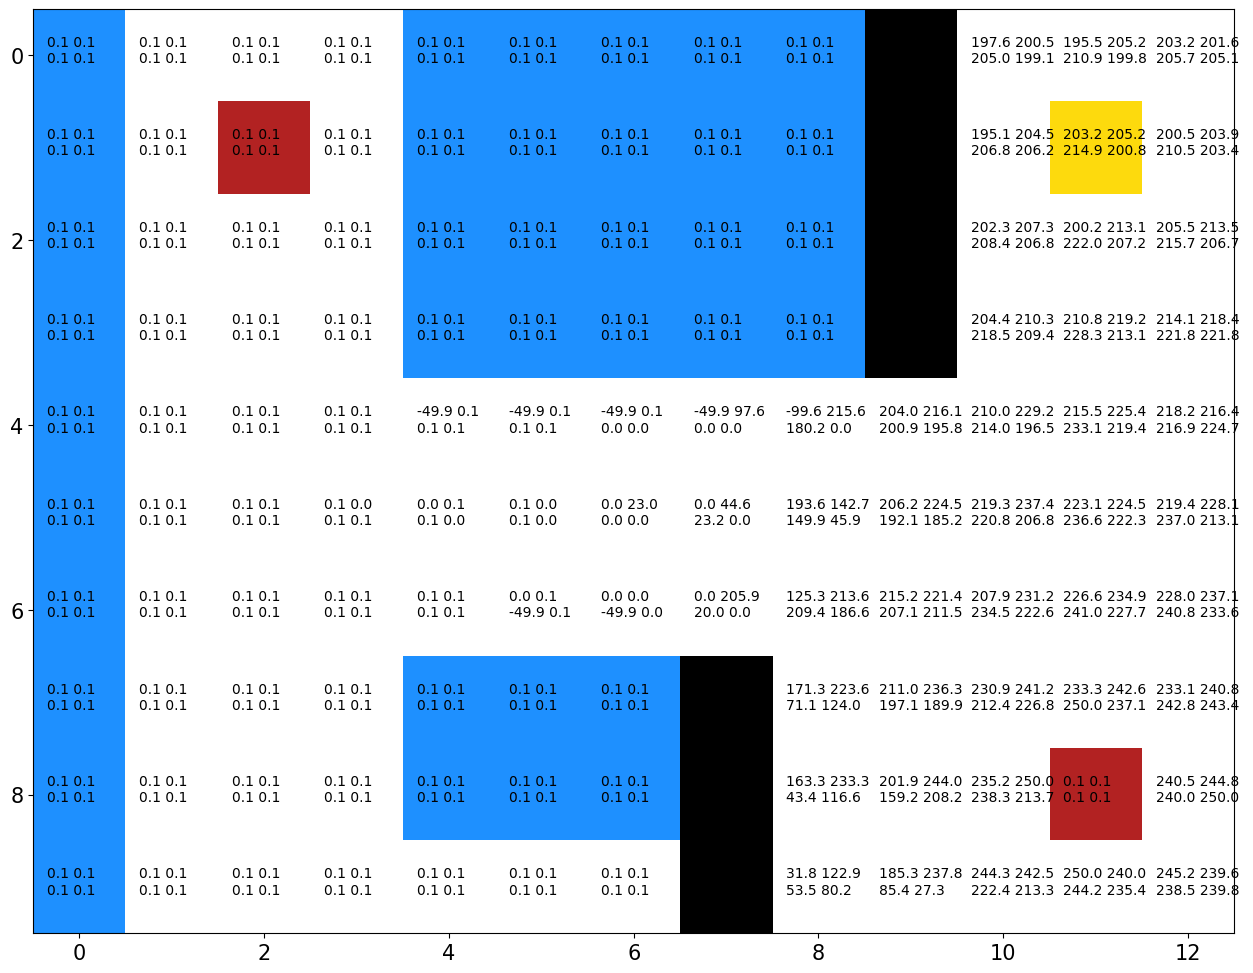

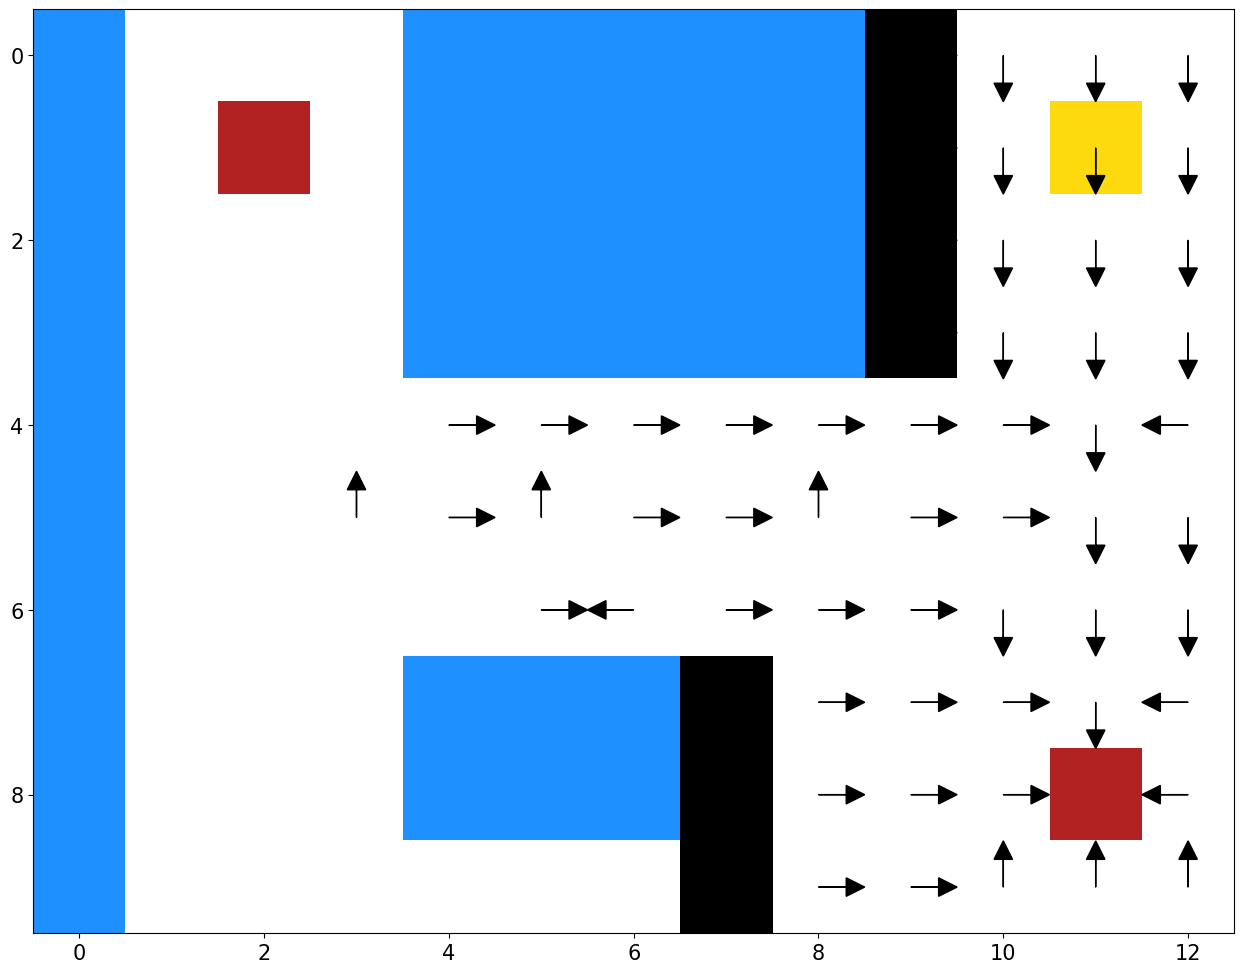

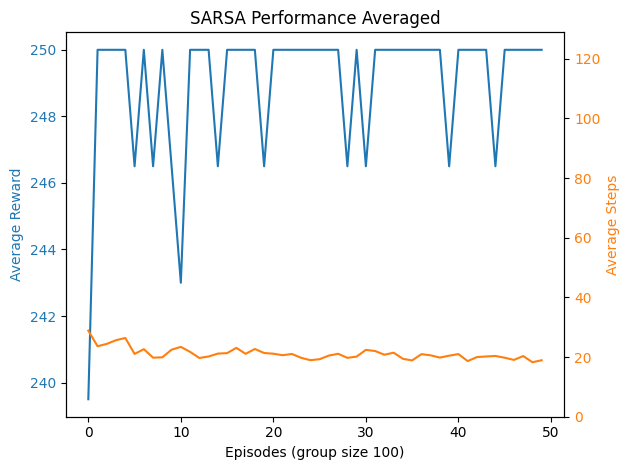

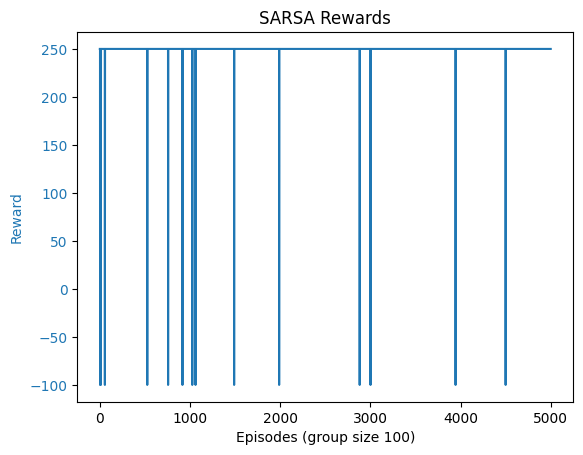

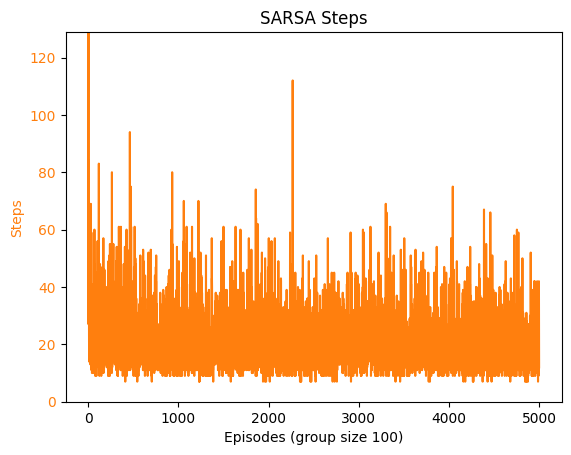

Rewards:
-100.0 14
250.0 4986
0 | 0.0s left (5000 steps) | [ 104857600.0 steps / s ]      [0.0s]
100 | 6.0s left (4900 steps) | [ 746.47 steps / s ]      [0.0s]
200 | 5.0s left (4800 steps) | [ 868.54 steps / s ]      [0.0s]
300 | 5.0s left (4700 steps) | [ 864.45 steps / s ]      [0.0s]
400 | 5.0s left (4600 steps) | [ 915.58 steps / s ]      [0.0s]
500 | 5.0s left (4500 steps) | [ 842.39 steps / s ]      [0.0s]
600 | 5.0s left (4400 steps) | [ 844.48 steps / s ]      [0.0s]
700 | 4.0s left (4300 steps) | [ 880.03 steps / s ]      [0.0s]
800 | 4.0s left (4200 steps) | [ 860.6 steps / s ]      [0.0s]
900 | 5.0s left (4100 steps) | [ 816.48 steps / s ]      [1.0s]
1000 | 4.0s left (4000 steps) | [ 931.71 steps / s ]      [1.0s]
1100 | 4.0s left (3900 steps) | [ 794.83 steps / s ]      [1.0s]
1200 | 4.0s left (3800 steps) | [ 818.72 steps / s ]      [1.0s]
1300 | 4.0s left (3700 steps) | [ 845.61 steps / s ]      [1.0s]
1400 | 3.0s left (3600 steps) | [ 909.8 steps / s ]      [1.0s]
1500

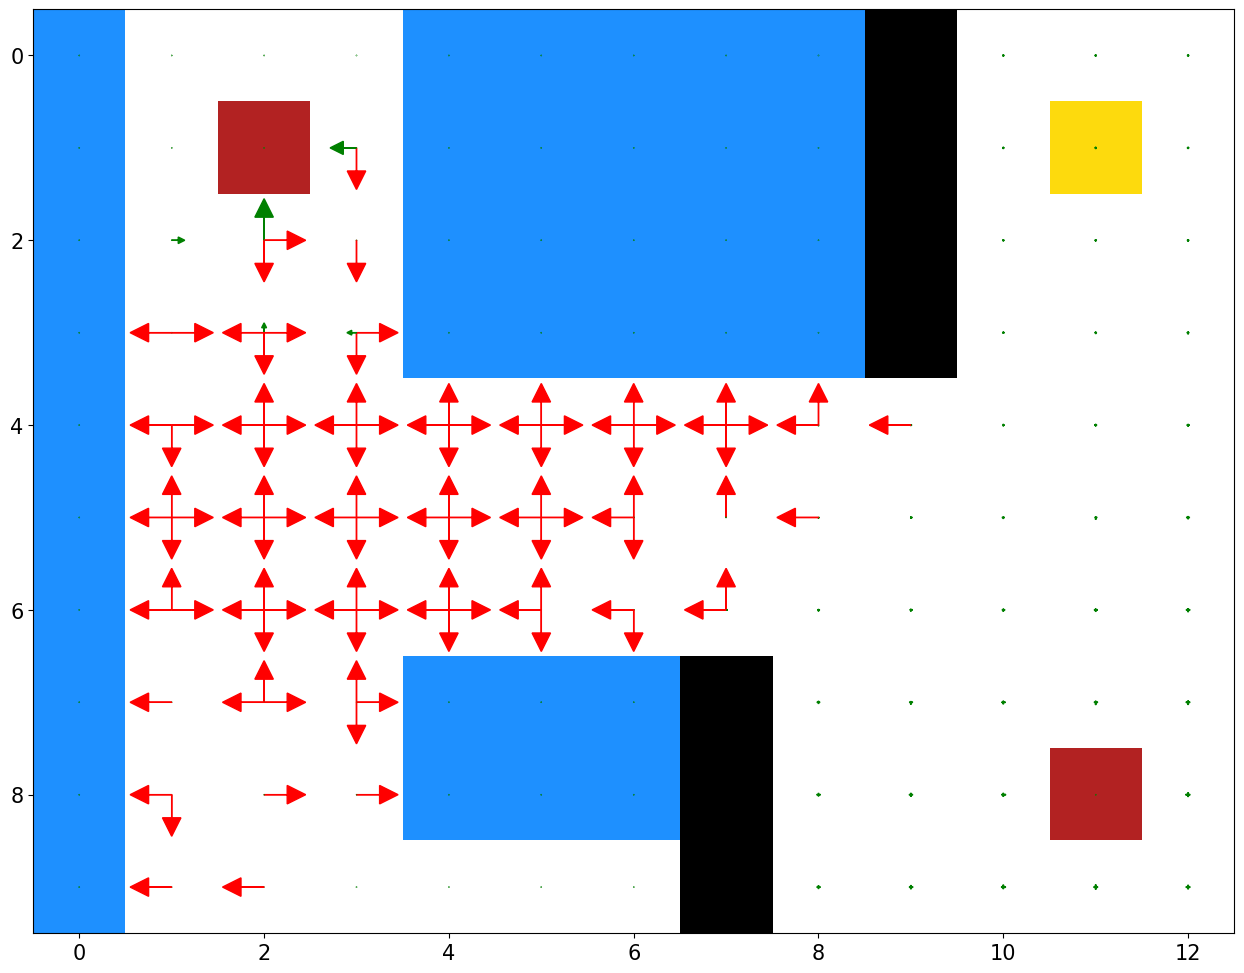

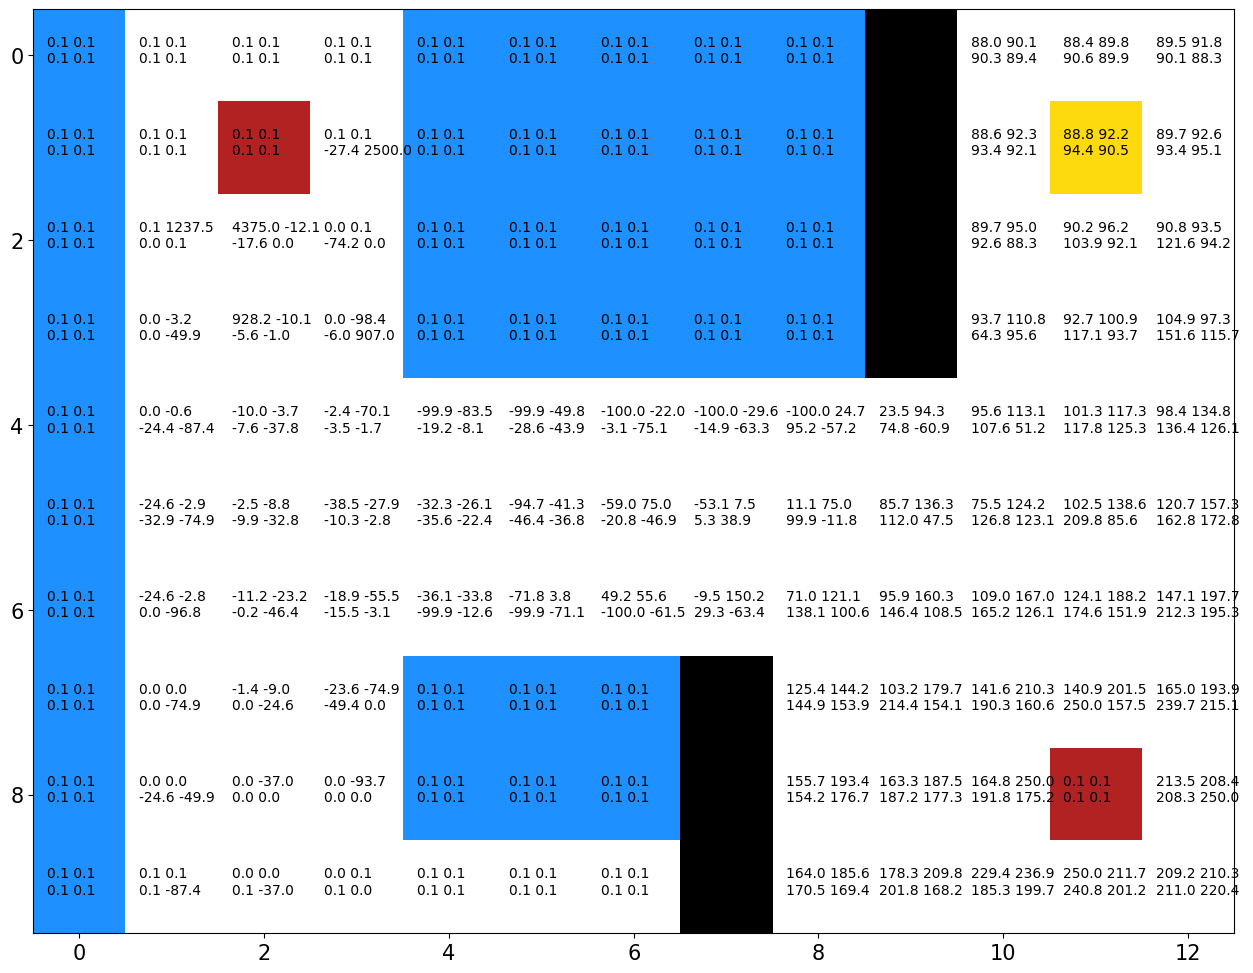

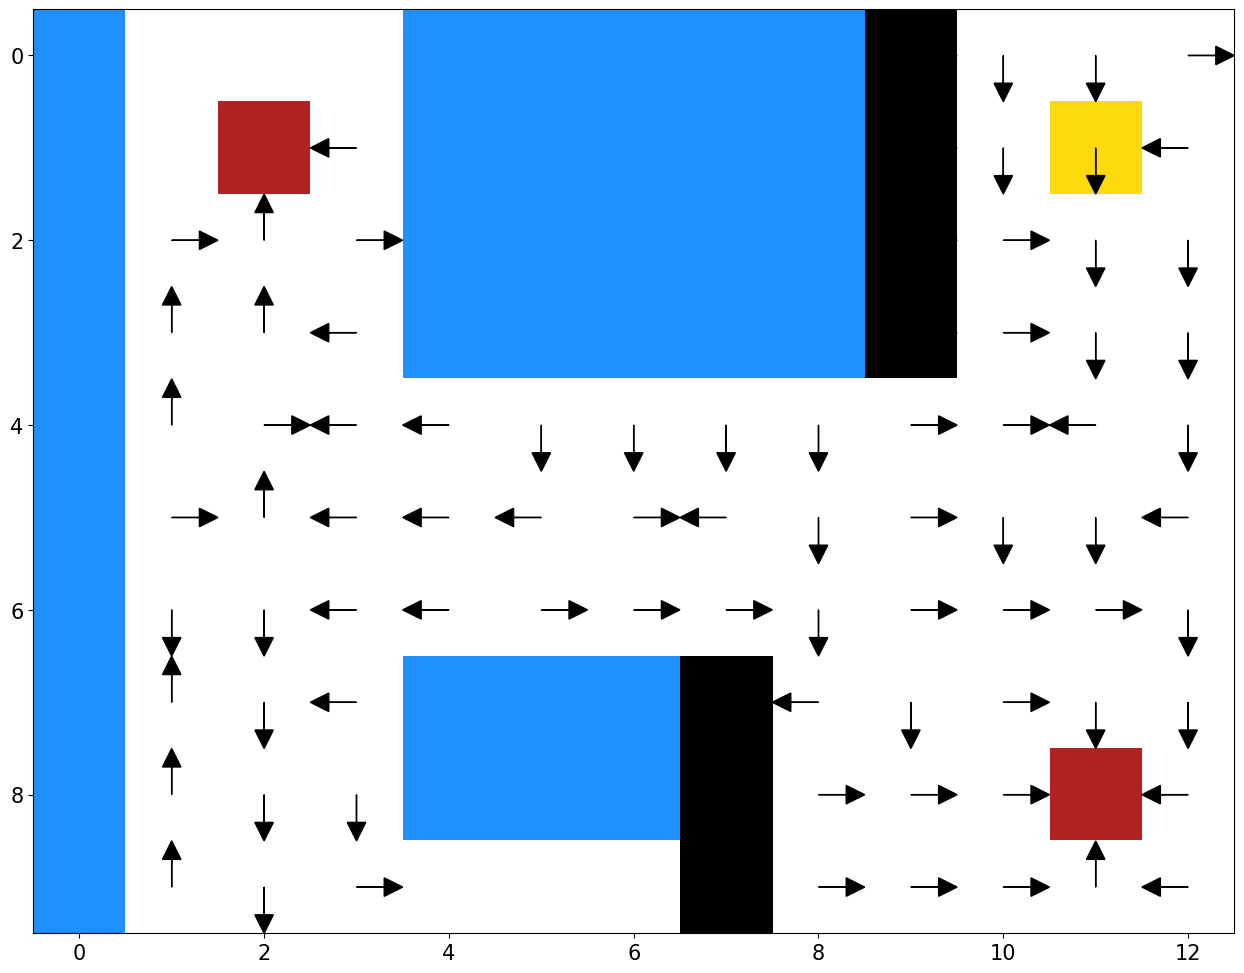

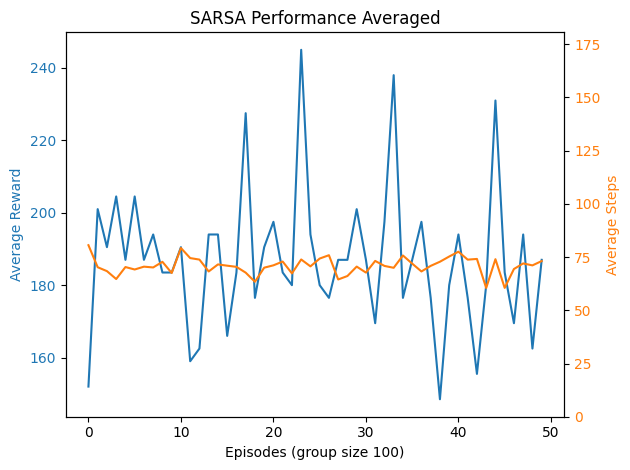

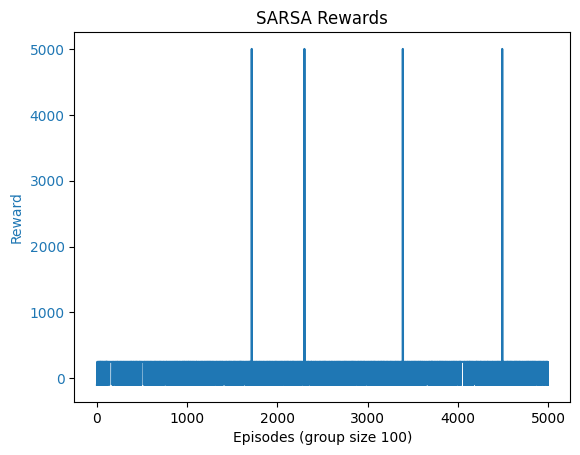

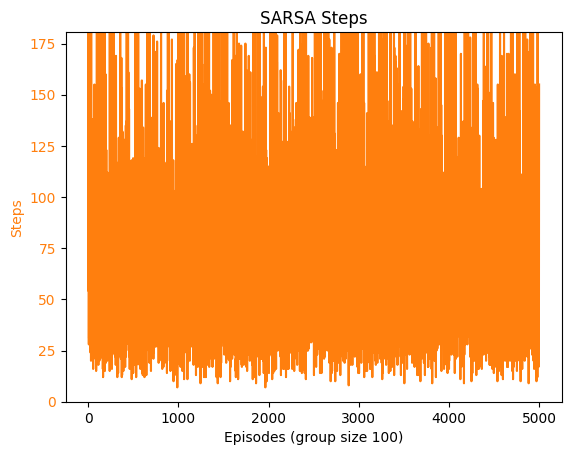

Rewards:
-100.0 953
250.0 4043
5000.0 4


In [388]:
# Sersa algorithm with epsilon-greedy policy

def epsilon_greedy(state, Q, epsilon, deterministic = False):
    if np.random.random() < epsilon:
      # explore randomly
      return np.random.randint(0, 4)
    else:
      # take greedy action
      best_reward = np.max(Q[state])
      best_actions = np.flatnonzero(Q[state] == best_reward)
      if deterministic:
        return best_actions[0]
      return np.random.choice(best_actions)

def learn_policy_sarsa(env: GridWorld, 
                       n_episodes: int=1, 
                       eta=0.1, 
                       gamma=0.1, 
                       epsilon=0.1
                      ) -> tuple[np.ndarray, list[float], list[int]]:
    """
    Solve a given GridWorld environment using SARSA or Q-learning

    Args:
        env: The grid-world environment that will return states and rewards when given actions.
        n_episodes: Number of episodes for which to run learning.

    Returns:
        policy: A 2D array that represents the best action to take from each state location.
        total_rewards: Corresponding list of successive total non-discounted sum of reward for each trial
        episode_lengths: Corresponding list of episode lengths.
    """

    ####
    # Add your code here
    # WARNING: this agent should only access env.reset() and env.step()
    ####
    debug = 0
    feedback_steps = 100
    Q = np.ones((env.get_state_size(), 4)) * 0.1
    total_rewards = []
    episode_lengths = []
    most_recent_action_from_state = np.ones(env.get_gridshape()) * -1
    then = time.time()
    start_time = then
    for episode in range(n_episodes):
        if (episode % feedback_steps == 0):
            now = time.time()
            dt = now - then
            remaining = (n_episodes - episode)
            speed = feedback_steps / dt
            est = remaining / speed
            print(f"{episode} | {np.trunc(est)}s left ({remaining} steps) | [ {np.trunc(100*speed)/100} steps / s ]      [{np.trunc(now - start_time)}s]")
            then = time.time()
        greedy_actions = np.ones(env.get_gridshape())
        _, state, reward, done = env.reset()
        action = epsilon_greedy(state, Q, epsilon)
        total_rewards.append(0)
        episode_lengths.append(0)
        while not done:
            _, new_state, reward, done = env.step(action)

            total_rewards[episode] += reward
            episode_lengths[episode] += 1
            state_as_tuple = env.get_loc_from_state(state)
            most_recent_action_from_state[*state_as_tuple] = action
            new_action = epsilon_greedy(new_state, Q, epsilon)
            if (done):
                delta = reward - Q[state][action]
            else:
                delta = reward + gamma*Q[new_state][new_action] - Q[state][action]
            Q[state][action] += eta * delta
            state = new_state
            action = new_action
    for state in range(len(Q)):
        i,j = env.get_loc_from_state(state)
        greedy_actions[i][j] = epsilon_greedy_safe(state, Q, -1, True) if most_recent_action_from_state[i][j] != -1 else -1
    policy = greedy_actions
    return policy, total_rewards, episode_lengths, Q

def train(env, n_episodes, eta, gamma, epsilon):
    policy, total_rewards, total_steps, Q = learn_policy_sarsa(env,
                                                          n_episodes,
                                                          eta,
                                                          gamma,
                                                          epsilon,
                                                           )
    # Plotting
    draw_grid_Q_arrows(env, Q)
    draw_grid_text(env, Q)
    paint_gridworld(env, actions=policy)
    plot_rewards_and_steps(total_rewards, total_steps)
    values, counts = np.unique(total_rewards, return_counts=True)
    rewards_occurences = dict(zip(values, counts))
    values, counts = np.unique(total_steps, return_counts=True)
    steps_occurences = dict(zip(values, counts))
    print("Rewards:")
    for v in rewards_occurences:
        print(v, rewards_occurences[v])










import time

env1 = GridWorld(goal_locations=[(1, 2)], goal_rewards=[5000])

# plot 1

train(env1,
      n_episodes = 5000,
      eta= 0.5,
      gamma = 1 - 0.01,
      epsilon = 0.1
       )


env2 = GridWorld(goal_locations=[(1,2), (8,11)], goal_rewards=[5000, 250])


# plot 2
train(env2,
    n_episodes = 5000,
      eta= 0.5,
      gamma = 1 - 0.01,
      epsilon = 0.1
     )

# plot 3
train(env2,
    n_episodes = 5000,
      eta= 0.5,
      gamma = 1 - 0.01,
      epsilon = 0.5
     )

# plot 4
train(env2,
    n_episodes = 5000,
      eta= 0.5,
      gamma = 1 - 0.01,
      epsilon = 0.9
     )



0 | 0.0s left (4000 steps) | [ 83886080.0 steps / s ]      [0.0s]
100 | 18.0s left (3900 steps) | [ 213.03 steps / s ]      [0.0s]
200 | 21.0s left (3800 steps) | [ 179.49 steps / s ]      [1.0s]
300 | 18.0s left (3700 steps) | [ 199.22 steps / s ]      [1.0s]
400 | 15.0s left (3600 steps) | [ 225.64 steps / s ]      [1.0s]
500 | 13.0s left (3500 steps) | [ 250.05 steps / s ]      [2.0s]
600 | 13.0s left (3400 steps) | [ 254.13 steps / s ]      [2.0s]
700 | 16.0s left (3300 steps) | [ 200.97 steps / s ]      [3.0s]
800 | 19.0s left (3200 steps) | [ 165.8 steps / s ]      [3.0s]
900 | 28.0s left (3100 steps) | [ 110.06 steps / s ]      [4.0s]
1000 | 32.0s left (3000 steps) | [ 91.21 steps / s ]      [5.0s]
1100 | 28.0s left (2900 steps) | [ 102.49 steps / s ]      [6.0s]
1200 | 28.0s left (2800 steps) | [ 97.87 steps / s ]      [7.0s]
1300 | 20.0s left (2700 steps) | [ 133.25 steps / s ]      [8.0s]
1400 | 21.0s left (2600 steps) | [ 122.24 steps / s ]      [9.0s]
1500 | 20.0s left (250

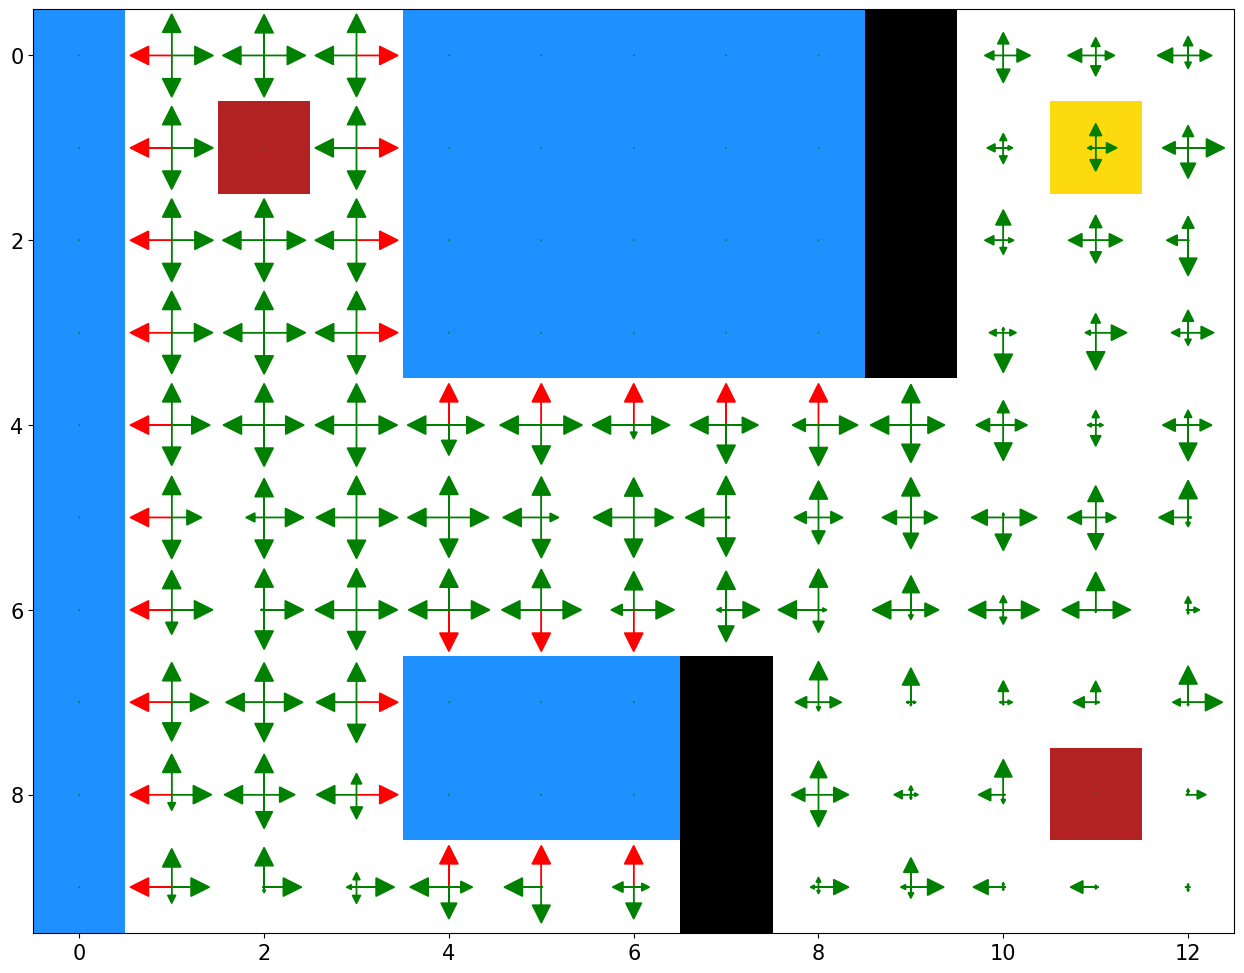

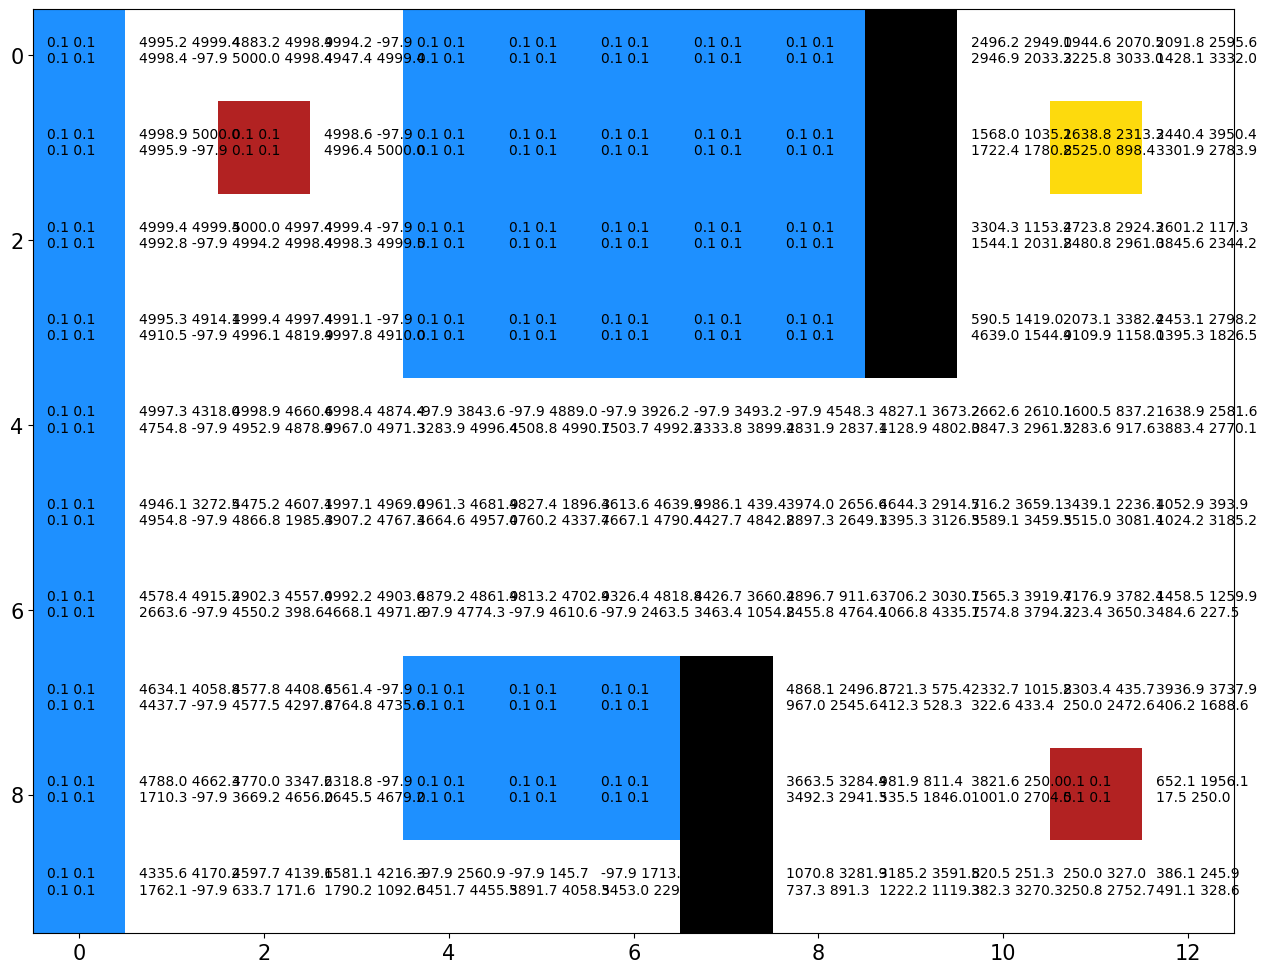

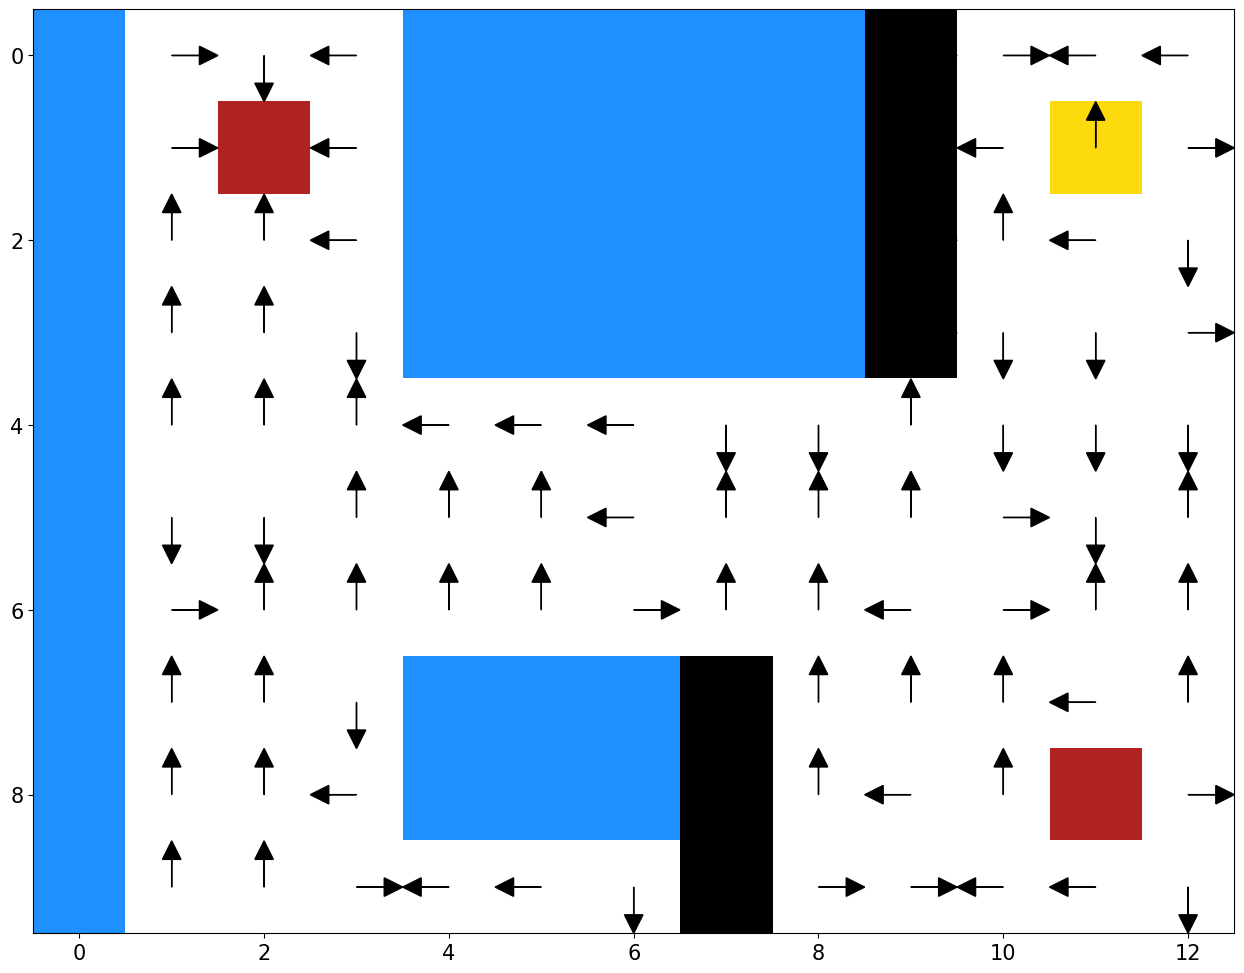

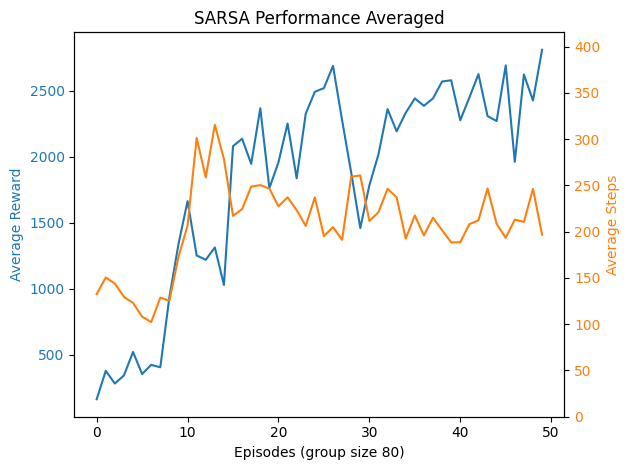

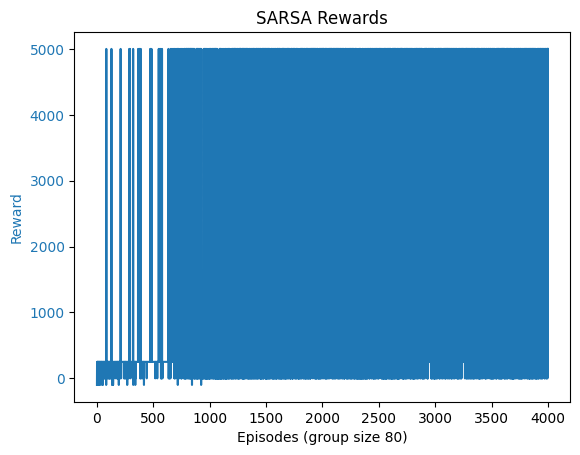

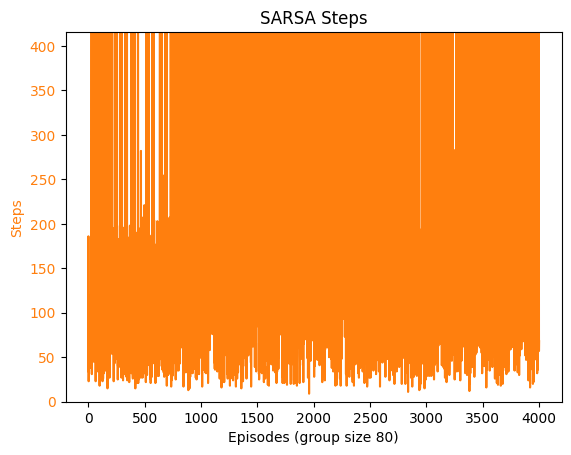

Rewards:
-100.0 27
0.0 984
250.0 1610
5000.0 1379
0 | 0.0s left (5000 steps) | [ 104857600.0 steps / s ]      [0.0s]
100 | 21.0s left (4900 steps) | [ 230.37 steps / s ]      [0.0s]
200 | 23.0s left (4800 steps) | [ 204.54 steps / s ]      [0.0s]
300 | 21.0s left (4700 steps) | [ 219.98 steps / s ]      [1.0s]
400 | 19.0s left (4600 steps) | [ 234.35 steps / s ]      [1.0s]
500 | 22.0s left (4500 steps) | [ 198.73 steps / s ]      [2.0s]
600 | 17.0s left (4400 steps) | [ 250.61 steps / s ]      [2.0s]
700 | 18.0s left (4300 steps) | [ 229.54 steps / s ]      [3.0s]
800 | 19.0s left (4200 steps) | [ 219.06 steps / s ]      [3.0s]
900 | 25.0s left (4100 steps) | [ 161.73 steps / s ]      [4.0s]
1000 | 22.0s left (4000 steps) | [ 178.86 steps / s ]      [4.0s]
1100 | 19.0s left (3900 steps) | [ 195.41 steps / s ]      [5.0s]
1200 | 22.0s left (3800 steps) | [ 171.55 steps / s ]      [5.0s]
1300 | 18.0s left (3700 steps) | [ 199.93 steps / s ]      [6.0s]
1400 | 23.0s left (3600 steps) | [

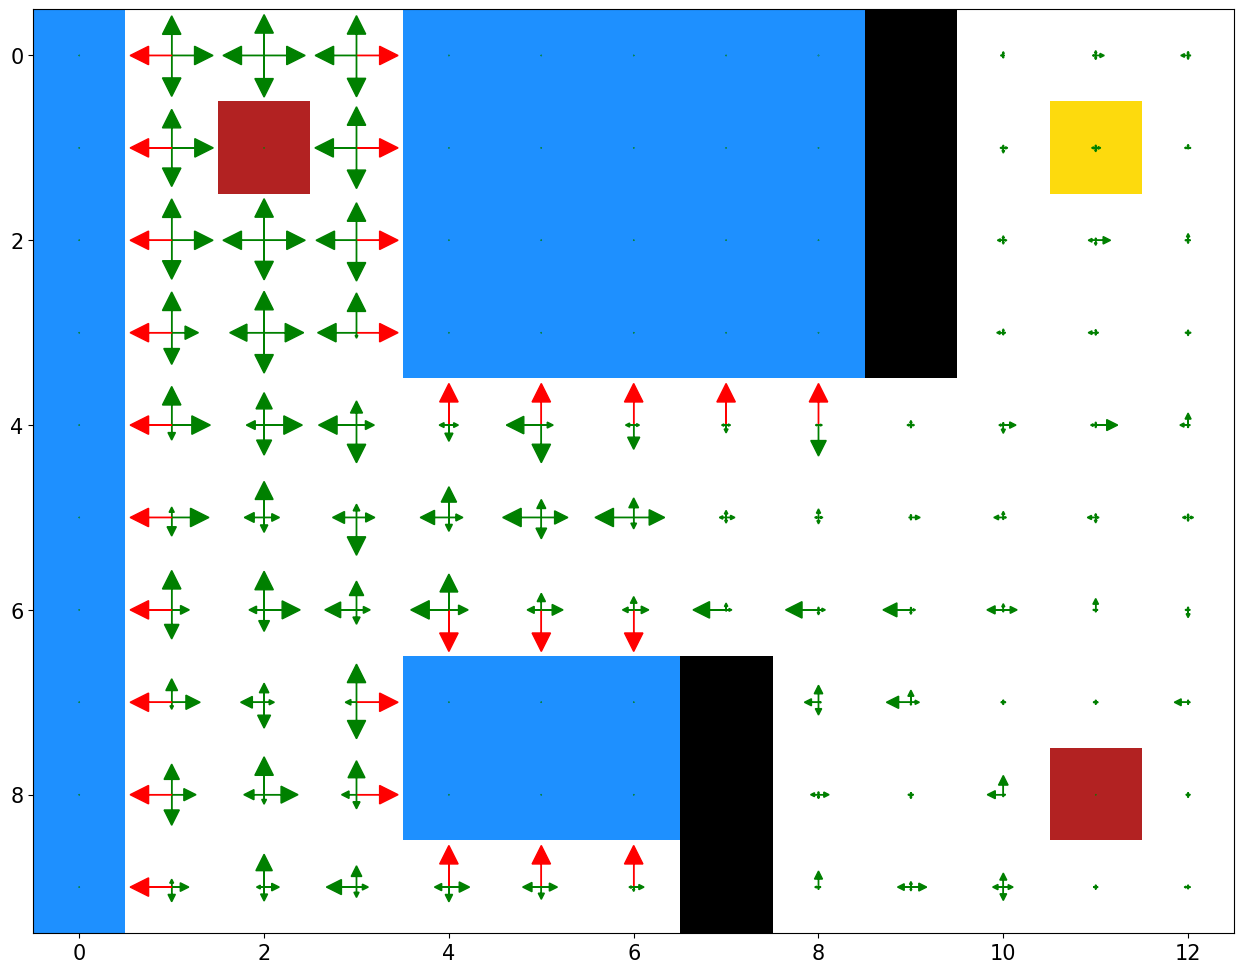

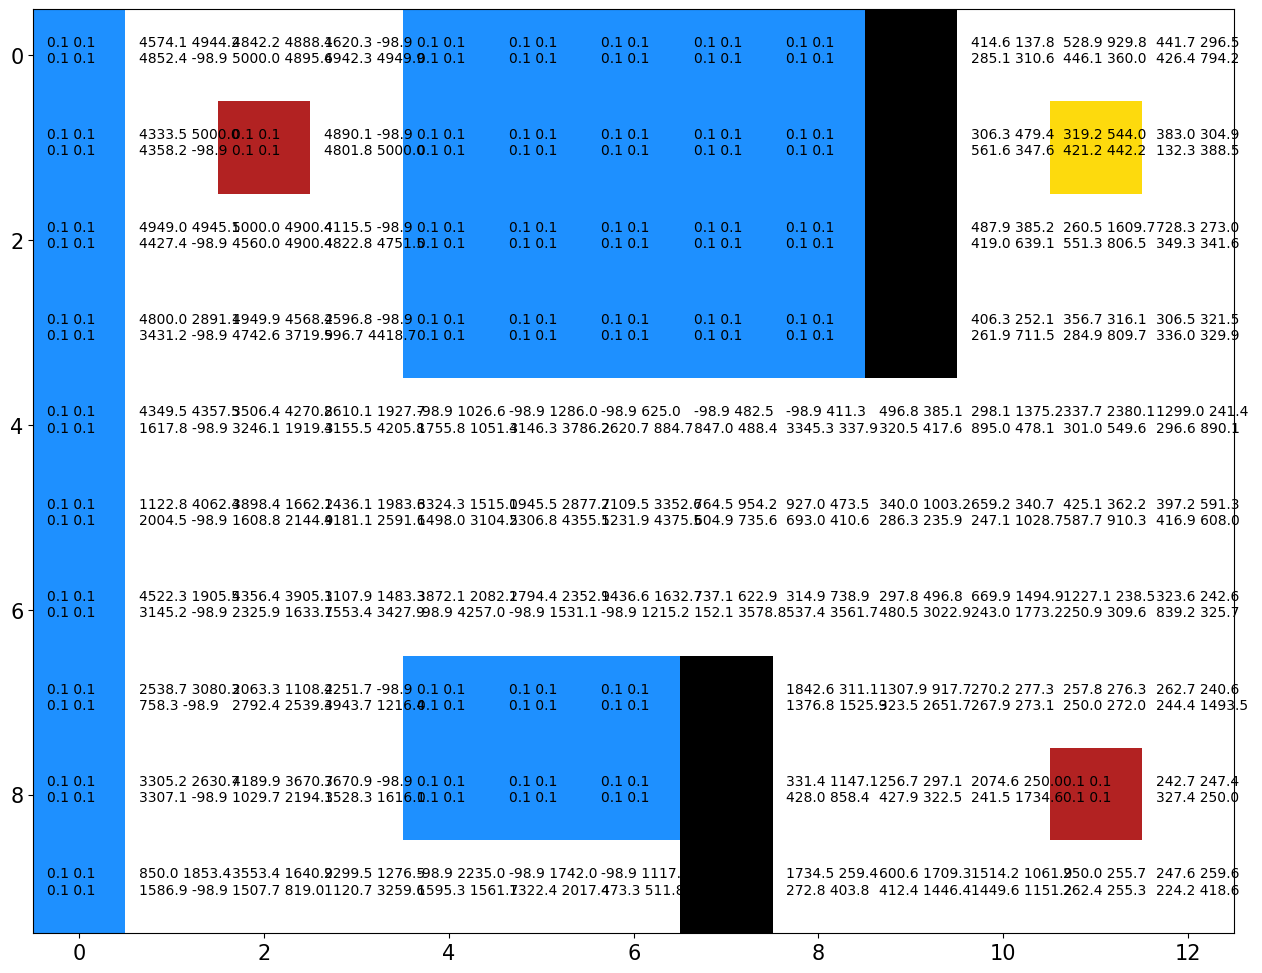

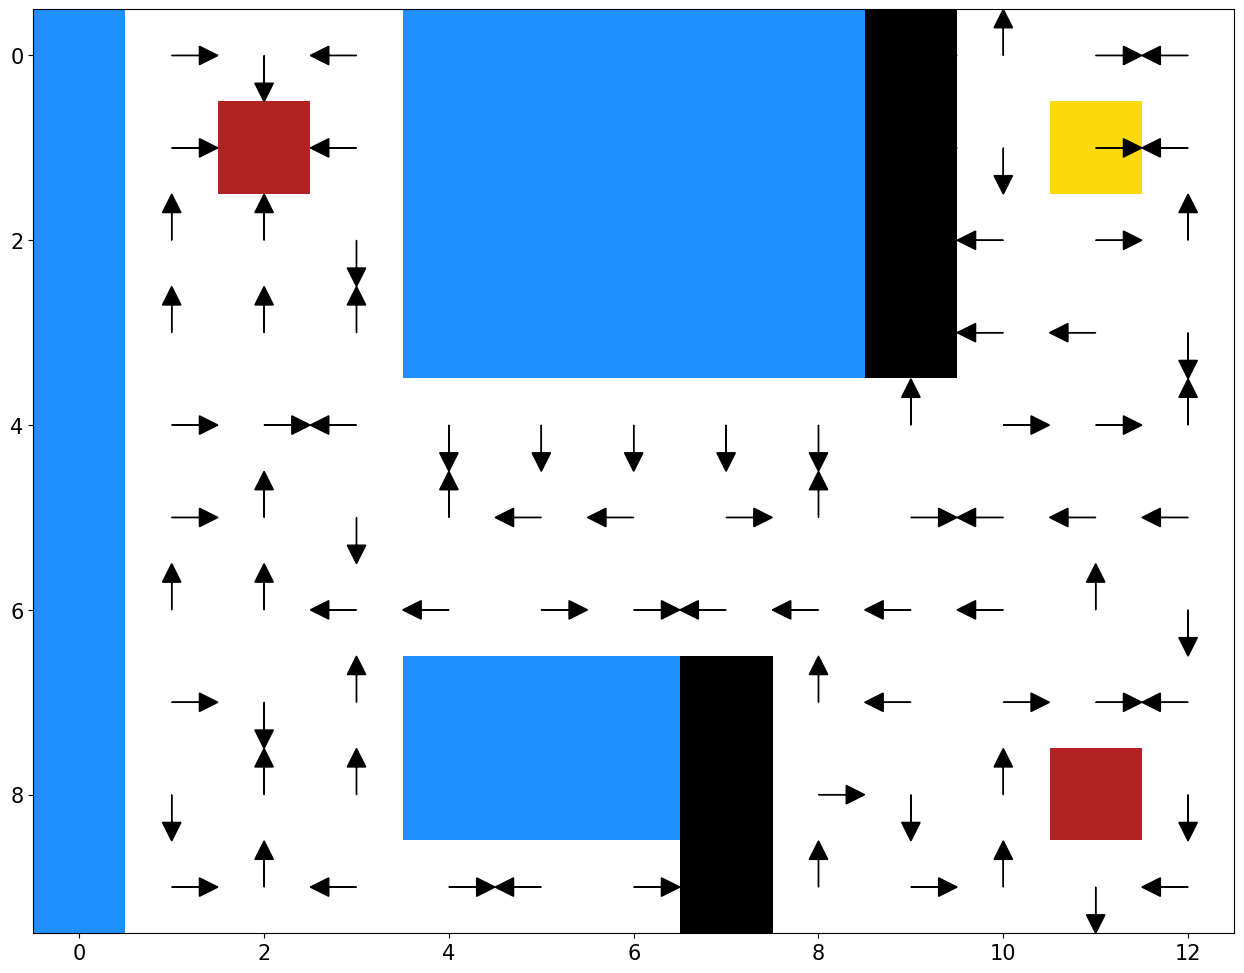

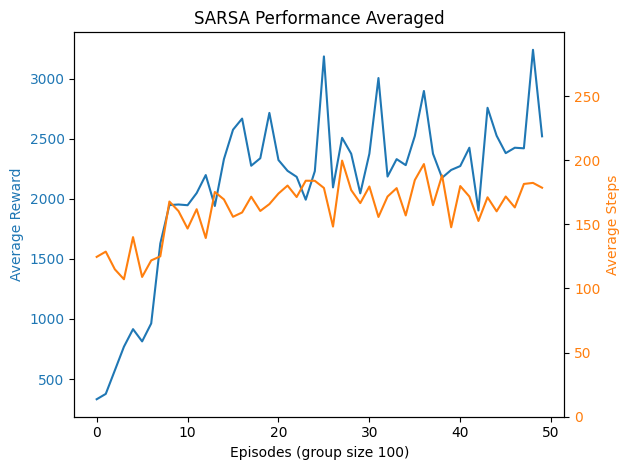

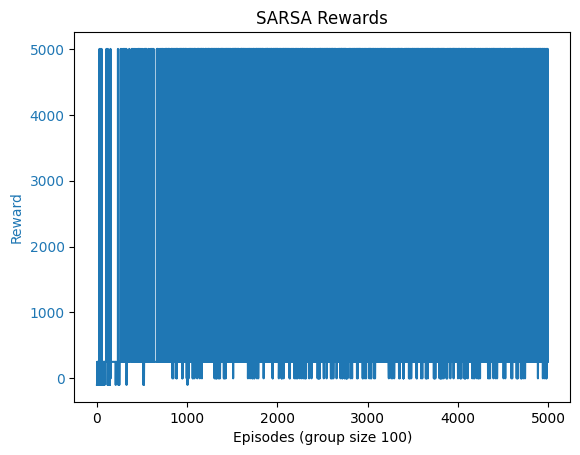

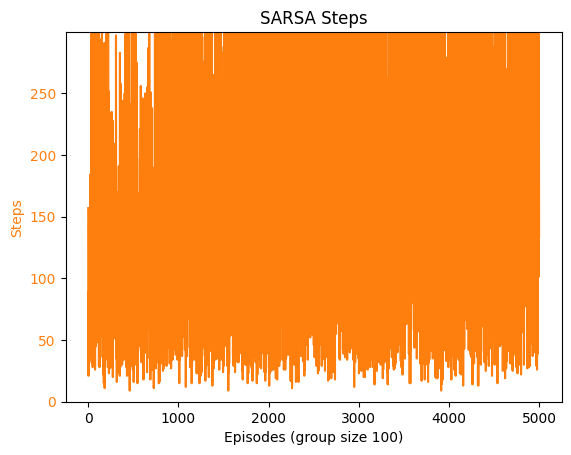

Rewards:
-100.0 27
0.0 181
250.0 2818
5000.0 1974


In [403]:
# Sersa algorithm with epsilon-greedy policy with epsilon schedule 1
import time
def epsilon_greedy(state, Q, epsilon, deterministic = False):
    if np.random.random() < epsilon:
      # explore randomly
      return np.random.randint(0, 4)
    else:
      # take greedy action
      best_reward = np.max(Q[state])
      best_actions = np.flatnonzero(Q[state] == best_reward)
      if deterministic:
        return best_actions[0]
      return np.random.choice(best_actions)

def learn_policy_sarsa(env: GridWorld, 
                       n_episodes: int=1, 
                       eta=0.1, 
                       gamma=0.1, 
                       epsilon_start=1,
                       epsilon_decay=100000,
                      ) -> tuple[np.ndarray, list[float], list[int]]:
    """
    Solve a given GridWorld environment using SARSA or Q-learning

    Args:
        env: The grid-world environment that will return states and rewards when given actions.
        n_episodes: Number of episodes for which to run learning.

    Returns:
        policy: A 2D array that represents the best action to take from each state location.
        total_rewards: Corresponding list of successive total non-discounted sum of reward for each trial
        episode_lengths: Corresponding list of episode lengths.
    """

    ####
    # Add your code here
    # WARNING: this agent should only access env.reset() and env.step()
    ####
    debug = 0
    feedback_steps = 100
    Q = np.ones((env.get_state_size(), 4)) * 0.1
    total_rewards = []
    episode_lengths = []
    most_recent_action_from_state = np.ones(env.get_gridshape()) * -1
    then = time.time()
    start_time = then
    for episode in range(n_episodes):
        if (episode % feedback_steps == 0):
            now = time.time()
            dt = now - then
            remaining = (n_episodes - episode)
            speed = feedback_steps / dt
            est = remaining / speed
            print(f"{episode} | {np.trunc(est)}s left ({remaining} steps) | [ {np.trunc(100*speed)/100} steps / s ]      [{np.trunc(now - start_time)}s]")
            then = time.time()
        greedy_actions = np.ones(env.get_gridshape())
        _, state, reward, done = env.reset()
        action = epsilon_greedy_safe(state, Q, epsilon_start)
        total_rewards.append(0)
        episode_lengths.append(0)
        while not done:
            _, new_state, reward, done = env.step(action)

            total_rewards[episode] += reward
            episode_lengths[episode] += 1
            state_as_tuple = env.get_loc_from_state(state)
            most_recent_action_from_state[*state_as_tuple] = action
            epsilon = epsilon_schedule(_, epsilon_start, epsilon_decay)

            
            new_action = epsilon_greedy_safe(new_state, Q, epsilon)

            
            if (done):
                delta = reward - Q[state][action]
            else:
                delta = reward + gamma*Q[new_state][new_action] - Q[state][action]
            Q[state][action] += eta * delta
            state = new_state
            action = new_action
    for state in range(len(Q)):
        i,j = env.get_loc_from_state(state)
        greedy_actions[i][j] = epsilon_greedy_safe(state, Q, -1, True) if most_recent_action_from_state[i][j] != -1 else -1
    policy = greedy_actions
    return policy, total_rewards, episode_lengths, Q

def epsilon_schedule(step, start, decay_time):
    return start * (decay_time - step) / decay_time

    

def train(env, n_episodes, eta, gamma, epsilon_start, epsilon_decay):
    policy, total_rewards, total_steps, Q = learn_policy_sarsa(env,
                                                          n_episodes,
                                                          eta,
                                                          gamma,
                                                          epsilon_start,
                                                          epsilon_decay
                                                           )
    # Plotting
    draw_grid_Q_arrows(env, Q)
    draw_grid_text(env, Q)
    paint_gridworld(env, actions=policy)
    plot_rewards_and_steps(total_rewards, total_steps)
    values, counts = np.unique(total_rewards, return_counts=True)
    rewards_occurences = dict(zip(values, counts))
    values, counts = np.unique(total_steps, return_counts=True)
    steps_occurences = dict(zip(values, counts))
    print("Rewards:")
    for v in rewards_occurences:
        print(v, rewards_occurences[v])

env2 = GridWorld(goal_locations=[(1,2), (8,11)], goal_rewards=[5000, 250])

# plot 5
train(env2,
    n_episodes = 4000,
      eta= 0.98,
      gamma = 1 - 0.0001,
      epsilon_start = 1,
      epsilon_decay = 250,
     )

# plot 6

train(env2,
      n_episodes = 5000,
      eta = 0.99,
      gamma = 1-0.01,
      epsilon_start = 1,
      epsilon_decay = 500
     )

0 | 0.0s left (1000 steps) | [ 20971520.0 steps / s ]
25 | 32.0s left (975 steps) | [ 30.37222907893224 steps / s ]
50 | 32.0s left (950 steps) | [ 29.001791149134462 steps / s ]
75 | 36.0s left (925 steps) | [ 25.494685041284537 steps / s ]
100 | 26.0s left (900 steps) | [ 33.82400662689583 steps / s ]
125 | 28.0s left (875 steps) | [ 30.875550662414383 steps / s ]
150 | 28.0s left (850 steps) | [ 29.726985156579126 steps / s ]
175 | 28.0s left (825 steps) | [ 29.42854111810809 steps / s ]
200 | 24.0s left (800 steps) | [ 32.5258753510198 steps / s ]
225 | 30.0s left (775 steps) | [ 25.500358097813596 steps / s ]
250 | 25.0s left (750 steps) | [ 29.052092153151197 steps / s ]
275 | 19.0s left (725 steps) | [ 36.43181056970566 steps / s ]
300 | 22.0s left (700 steps) | [ 30.536230934439956 steps / s ]
325 | 25.0s left (675 steps) | [ 26.470094495300984 steps / s ]
350 | 19.0s left (650 steps) | [ 33.555333967377045 steps / s ]
375 | 22.0s left (625 steps) | [ 28.331660395966036 steps /

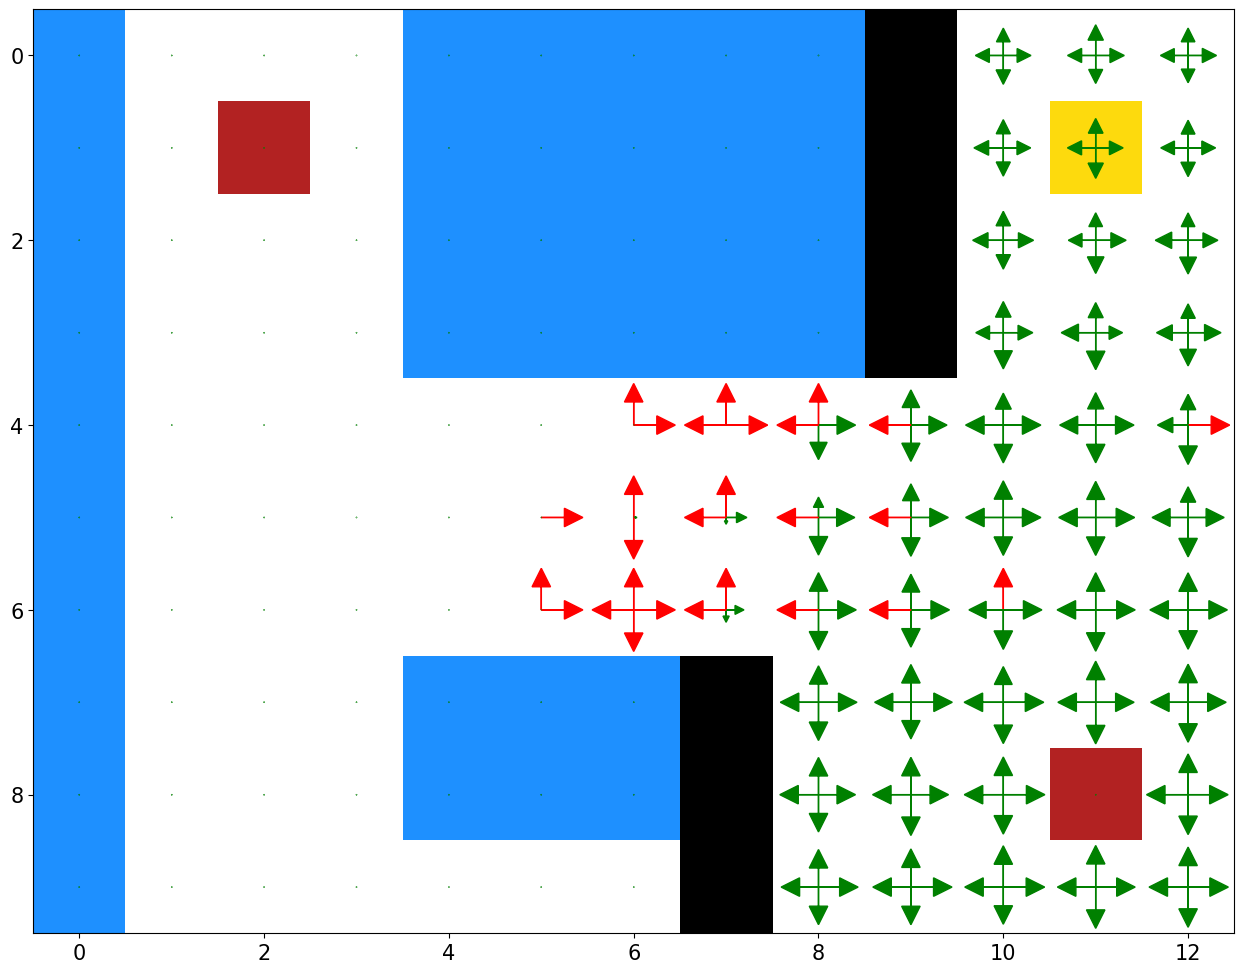

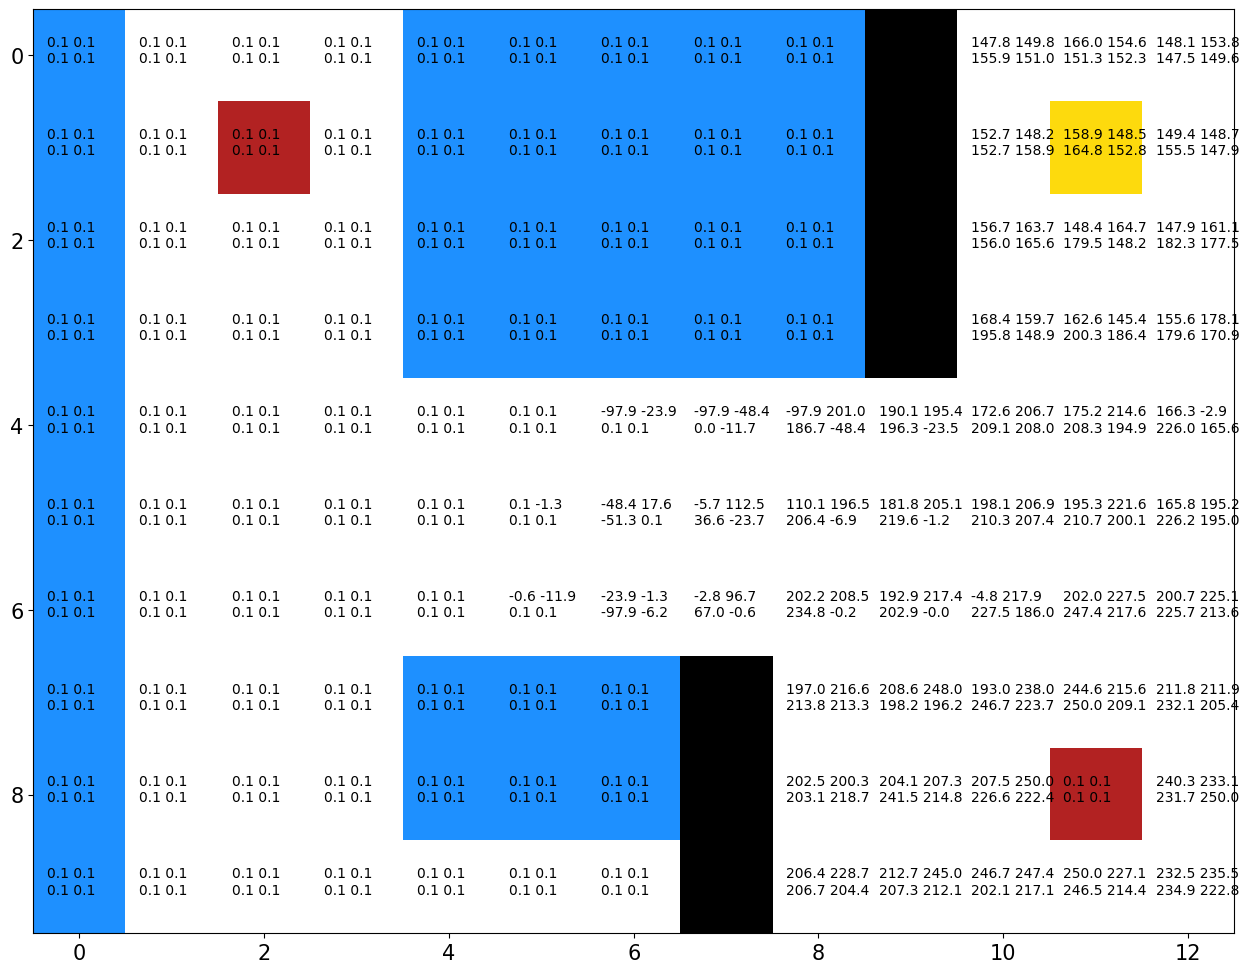

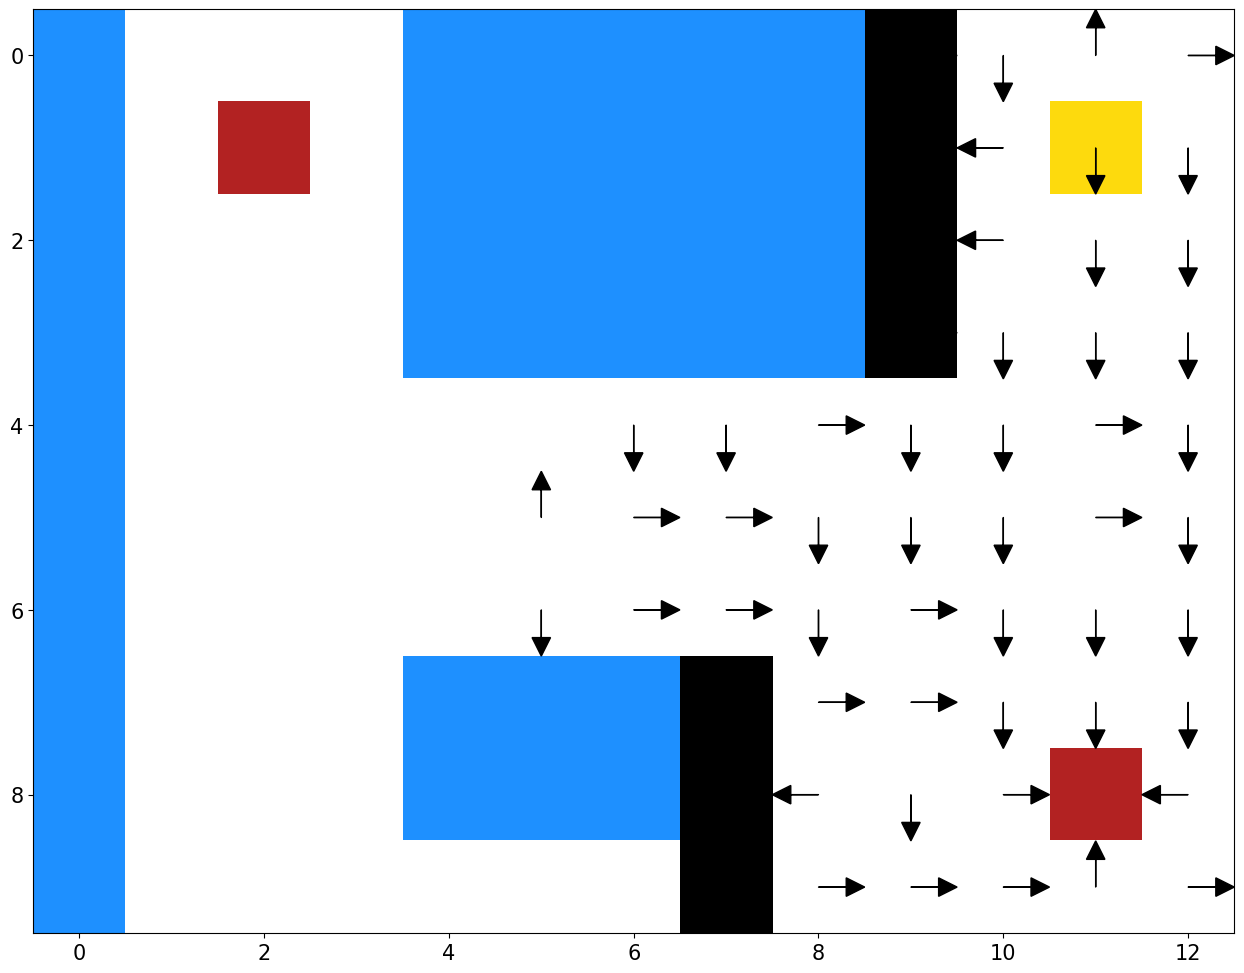

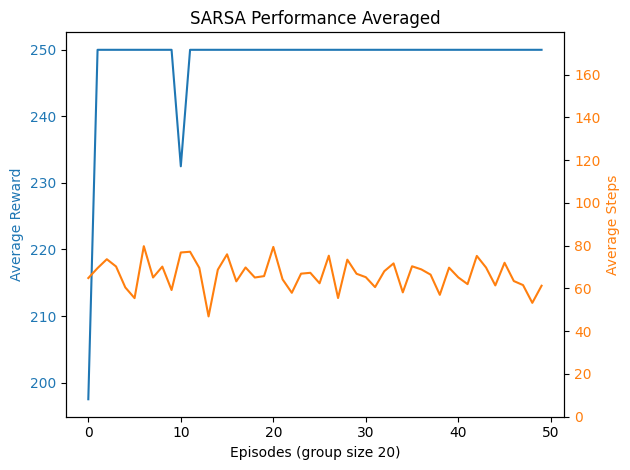

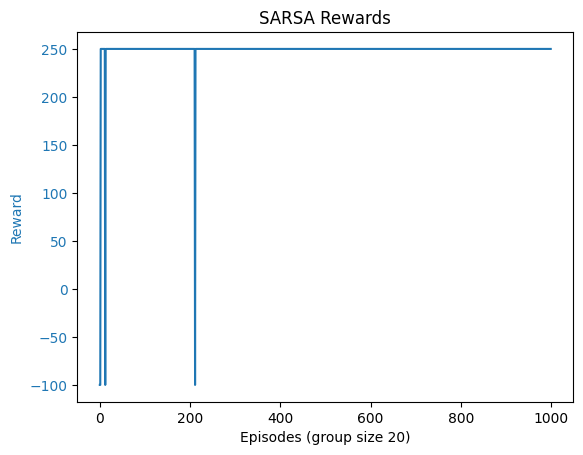

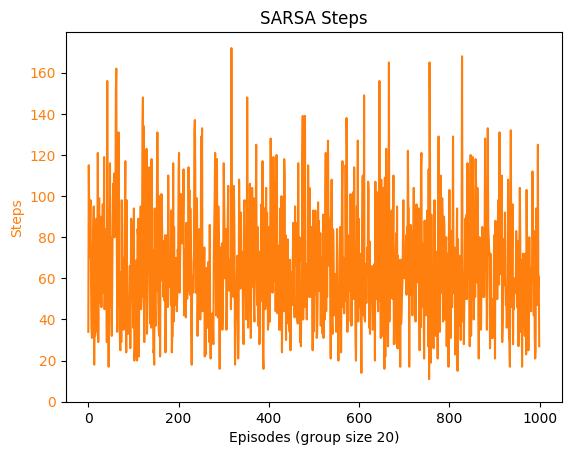

Rewards:
-100.0 4
250.0 996


In [371]:
# Sersa Lambda algorithm with epsilon greedy and epsilon greedy safe
def epsilon_greedy(state, Q, epsilon, deterministic = False):
    if np.random.random() < epsilon:
      # explore randomly
      return np.random.randint(0, 4)
    else:
      # take greedy action
      best_reward = np.max(Q[state])
      best_actions = np.flatnonzero(Q[state] == best_reward)
      if deterministic:
        return best_actions[0]
      return np.random.choice(best_actions)

def epsilon_greedy_safe(state, Q, epsilon, deterministic = False): # Only takes negative random option if absolutely necessary
    if np.random.random() < epsilon:
        # explore randomly, safely
        values = Q[state]
        if np.max(values) < 0:
            return np.random.randint(0, 4)
        safe_actions = np.flatnonzero(values >= 0)
        return np.random.choice(safe_actions)
    else:
      # take greedy action
      best_reward = np.max(Q[state])
      best_actions = np.flatnonzero(Q[state] == best_reward)
      if deterministic:
        return best_actions[0]
      return np.random.choice(best_actions)

def learn_policy_sarsa_lambda(env: GridWorld, 
                              n_episodes: int=1, 
                              eta=0.1, 
                              gamma=0.1, 
                              epsilon_start=0.1,
                              epsilon_decay=100000,
                              lambda_ = 1
                      ) -> tuple[np.ndarray, list[float], list[int]]:
    """
    Solve a given GridWorld environment using SARSA or Q-learning

    Args:
        env: The grid-world environment that will return states and rewards when given actions.
        n_episodes: Number of episodes for which to run learning.

    Returns:
        policy: A 2D array that represents the best action to take from each state location.
        total_rewards: Corresponding list of successive total non-discounted sum of reward for each trial
        episode_lengths: Corresponding list of episode lengths.
    """
    feedback_steps = 25
    
    Q = np.ones((env.get_state_size(), 4)) * 0.1
    total_rewards = []
    episode_lengths = []
    most_recent_action_from_state = np.ones(env.get_gridshape()) * -1
    then = time.time()
    for episode in range(n_episodes):
        if (episode % feedback_steps == 0):
            now = time.time()
            dt = now - then
            remaining = (n_episodes - episode)
            speed = feedback_steps / dt
            est = remaining / speed
            print(f"{episode} | {np.trunc(est)}s left ({remaining} steps) | [ {speed} steps / s ]")
            then = time.time()
        e = np.ones((env.get_state_size(), 4)) * 0
        greedy_actions = np.ones(env.get_gridshape())
        _, state, reward, done = env.reset()
        action = epsilon_greedy_safe(state, Q, epsilon_start)
        total_rewards.append(0)
        episode_lengths.append(0)
        while not done:
            _, new_state, reward, done = env.step(action)
            epsilon = epsilon_f(_, epsilon_start, epsilon_decay)
            loc = env.get_loc_from_state(new_state)
            total_rewards[episode] += reward
            episode_lengths[episode] += 1
            state_as_tuple = env.get_loc_from_state(state)
            most_recent_action_from_state[*state_as_tuple] = action

            if (done):
                delta = reward - Q[state][action]
                new_action = 0
            else:
                new_action = epsilon_greedy_safe(new_state, Q, epsilon)
                delta = reward + gamma*Q[new_state][new_action] - Q[state][action]
            e[state][action] += 1
            for state in range(len(Q)):
                for action in range(4):
                    Q[state][action] += eta * delta * e[state][action]
                    e[state][action] *= gamma * lambda_
            state = new_state
            action = new_action
    for state in range(len(Q)):
        i,j = env.get_loc_from_state(state)

        greedy_actions[i][j] = epsilon_greedy_safe(state, Q, -1, True) if most_recent_action_from_state[i][j] != -1 else -1
    #paint_gridworld(env, actions=greedy_actions)

    policy = greedy_actions


    return policy, total_rewards, episode_lengths, Q


def train(env, n_episodes, eta, gamma, epsilon_start, epsilon_decay, lambda_):
    policy, total_rewards, total_steps, Q = learn_policy_sarsa_lambda(env,
                                                          n_episodes,
                                                          eta,
                                                          gamma,
                                                          epsilon_start,
                                                          epsilon_decay,
                                                          lambda_
                                                           )
    # Plotting
    draw_grid_Q_arrows(env, Q)
    draw_grid_text(env, Q)
    paint_gridworld(env, actions=policy)
    plot_rewards_and_steps(total_rewards, total_steps)
    values, counts = np.unique(total_rewards, return_counts=True)
    rewards_occurences = dict(zip(values, counts))
    values, counts = np.unique(total_steps, return_counts=True)
    steps_occurences = dict(zip(values, counts))
    print("Rewards:")
    for v in rewards_occurences:
        print(v, rewards_occurences[v])


env2 = GridWorld(goal_locations=[(1,2), (8,11)], goal_rewards=[5000, 250])

# plot 7
train(env2,
    n_episodes = 1000,
      eta= 0.98,
      gamma = 1 - 0.01,
      epsilon_start = 1,
      epsilon_decay = 250,
      lambda_ = 0.5
     )

0 | 0.0s left (2000 steps) | [ 59918628.57 steps / s ]      [0.0s]
100 | 11.0s left (1900 steps) | [ 167.63 steps / s ]      [0.0s]
200 | 13.0s left (1800 steps) | [ 133.85 steps / s ]      [1.0s]
300 | 10.0s left (1700 steps) | [ 169.22 steps / s ]      [1.0s]
400 | 10.0s left (1600 steps) | [ 150.72 steps / s ]      [2.0s]
500 | 2.0s left (1500 steps) | [ 740.87 steps / s ]      [2.0s]
600 | 0.0s left (1400 steps) | [ 1467.64 steps / s ]      [2.0s]
700 | 0.0s left (1300 steps) | [ 1412.68 steps / s ]      [2.0s]
800 | 0.0s left (1200 steps) | [ 1511.46 steps / s ]      [2.0s]
900 | 0.0s left (1100 steps) | [ 1518.87 steps / s ]      [3.0s]
1000 | 0.0s left (1000 steps) | [ 1519.67 steps / s ]      [3.0s]
1100 | 0.0s left (900 steps) | [ 1430.58 steps / s ]      [3.0s]
1200 | 0.0s left (800 steps) | [ 1466.18 steps / s ]      [3.0s]
1300 | 0.0s left (700 steps) | [ 1515.27 steps / s ]      [3.0s]
1400 | 0.0s left (600 steps) | [ 1494.5 steps / s ]      [3.0s]
1500 | 0.0s left (500 st

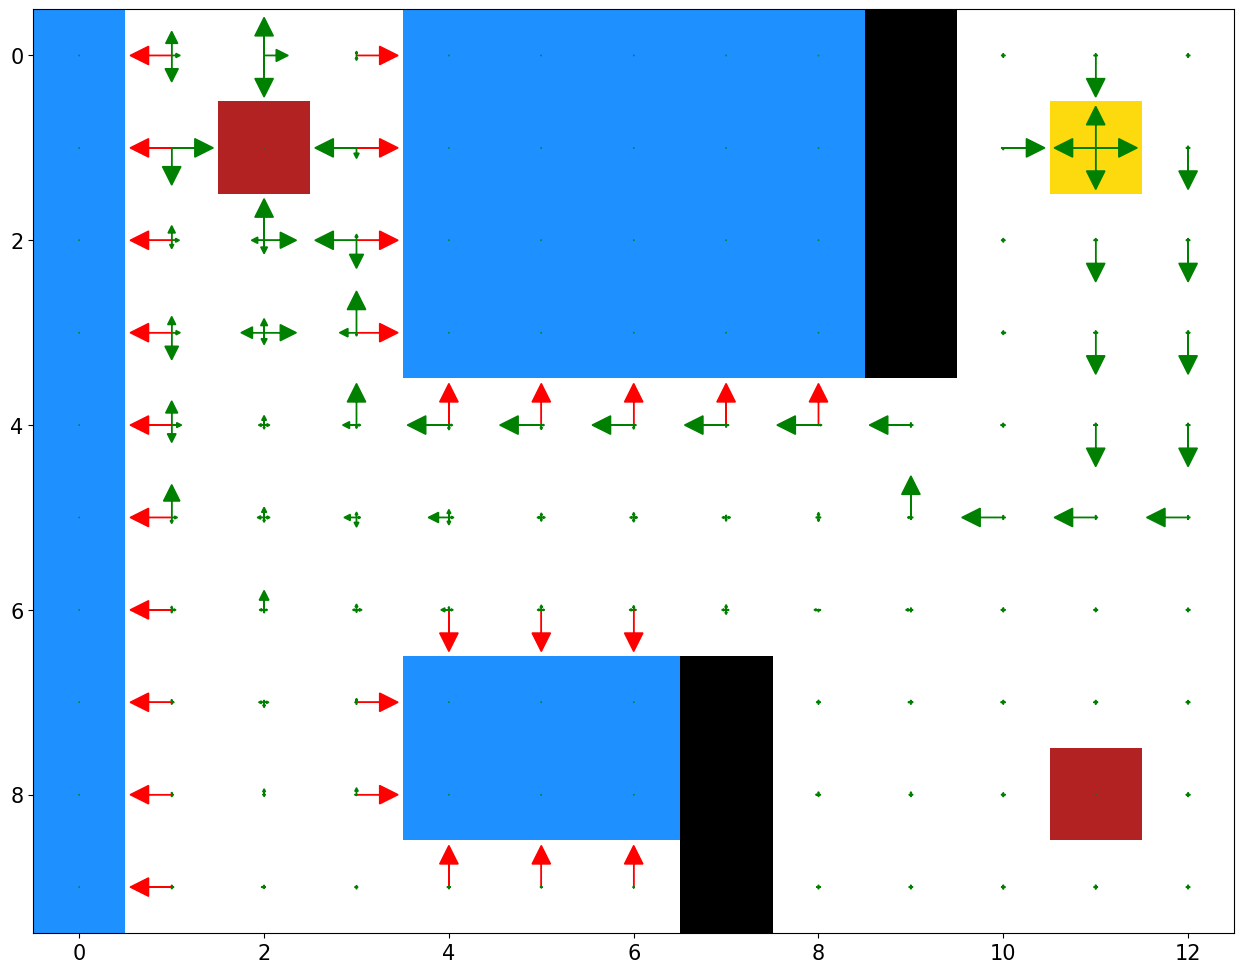

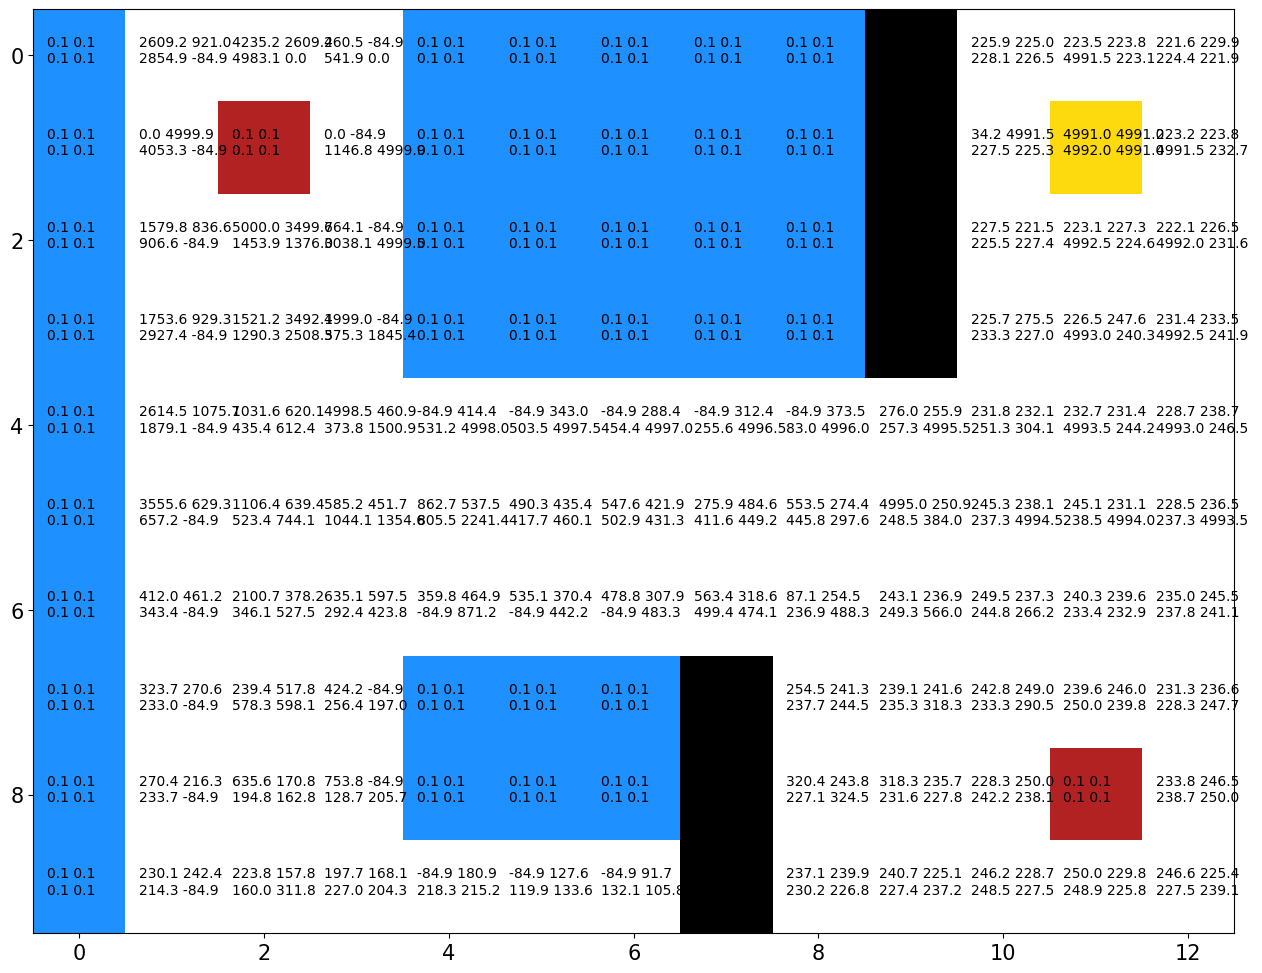

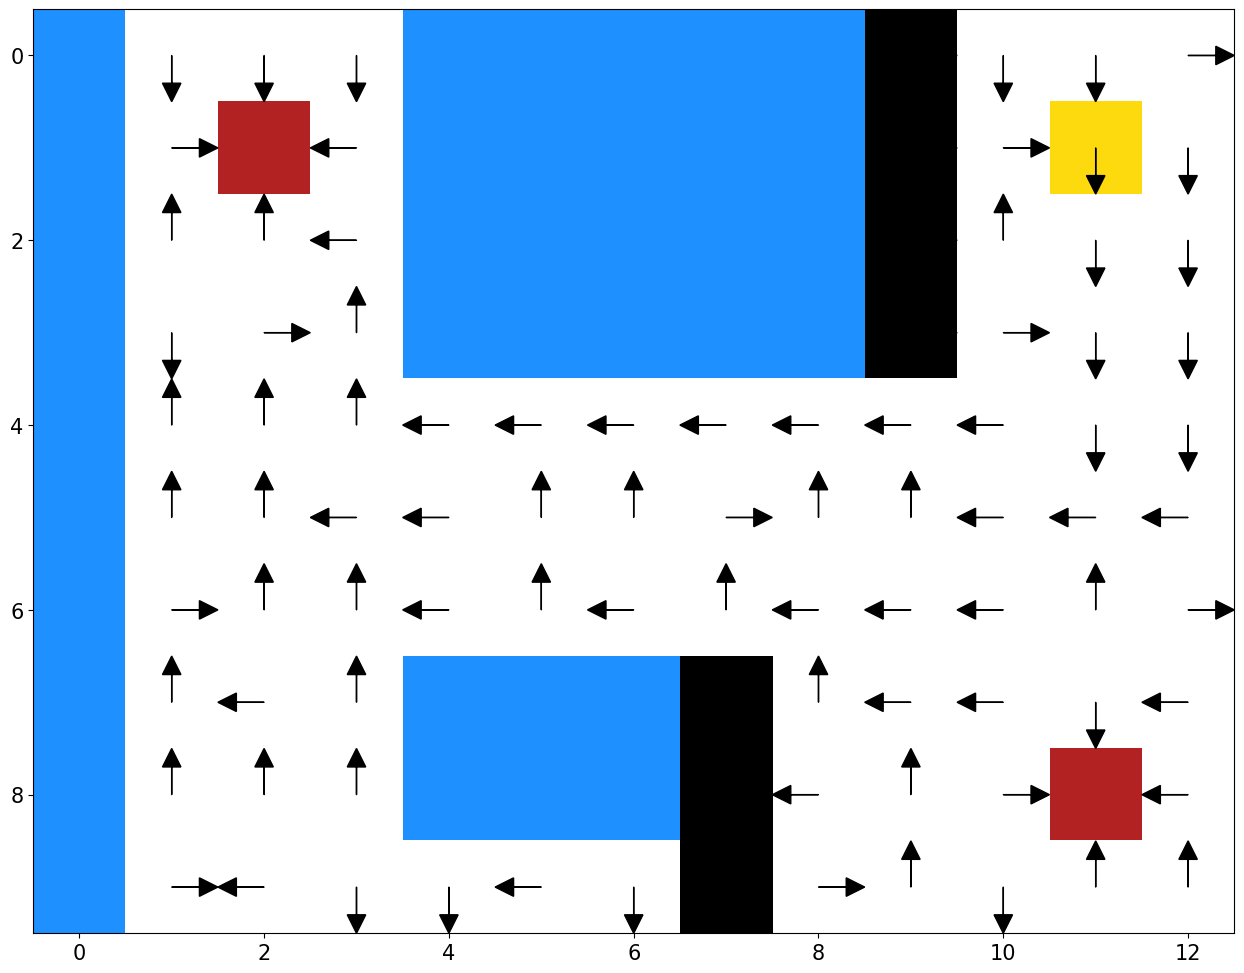

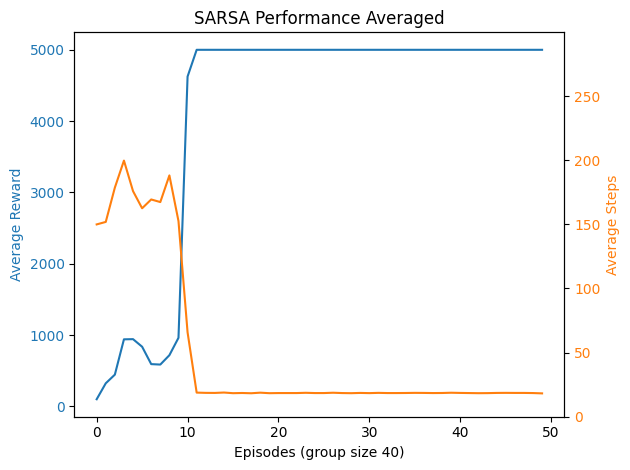

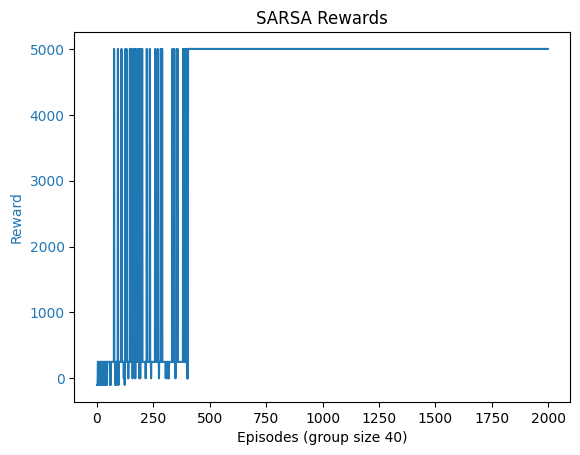

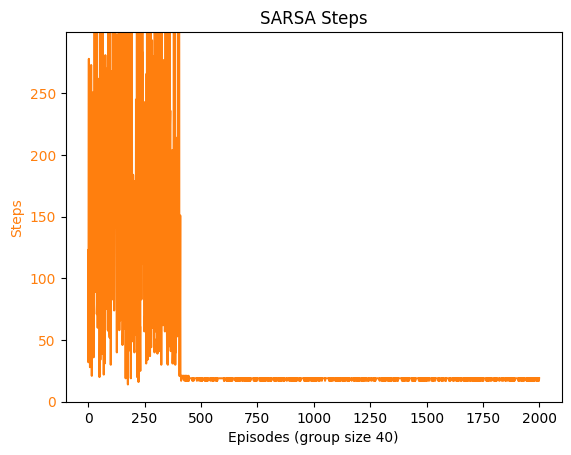

Rewards:
-100.0 27
0.0 16
250.0 324
5000.0 1633
0 | 0.0s left (1000 steps) | [ 83886080.0 steps / s ]      [0.0s]
100 | 4.0s left (900 steps) | [ 187.42 steps / s ]      [0.0s]
200 | 4.0s left (800 steps) | [ 165.45 steps / s ]      [1.0s]
300 | 4.0s left (700 steps) | [ 166.59 steps / s ]      [1.0s]
400 | 3.0s left (600 steps) | [ 156.65 steps / s ]      [2.0s]
500 | 0.0s left (500 steps) | [ 713.27 steps / s ]      [2.0s]
600 | 0.0s left (400 steps) | [ 1699.87 steps / s ]      [2.0s]
700 | 0.0s left (300 steps) | [ 1646.91 steps / s ]      [2.0s]
800 | 0.0s left (200 steps) | [ 1642.56 steps / s ]      [2.0s]
900 | 0.0s left (100 steps) | [ 1604.98 steps / s ]      [2.0s]
20000.0 -339.94
len(neg): 27, neg[-1]: -84.985


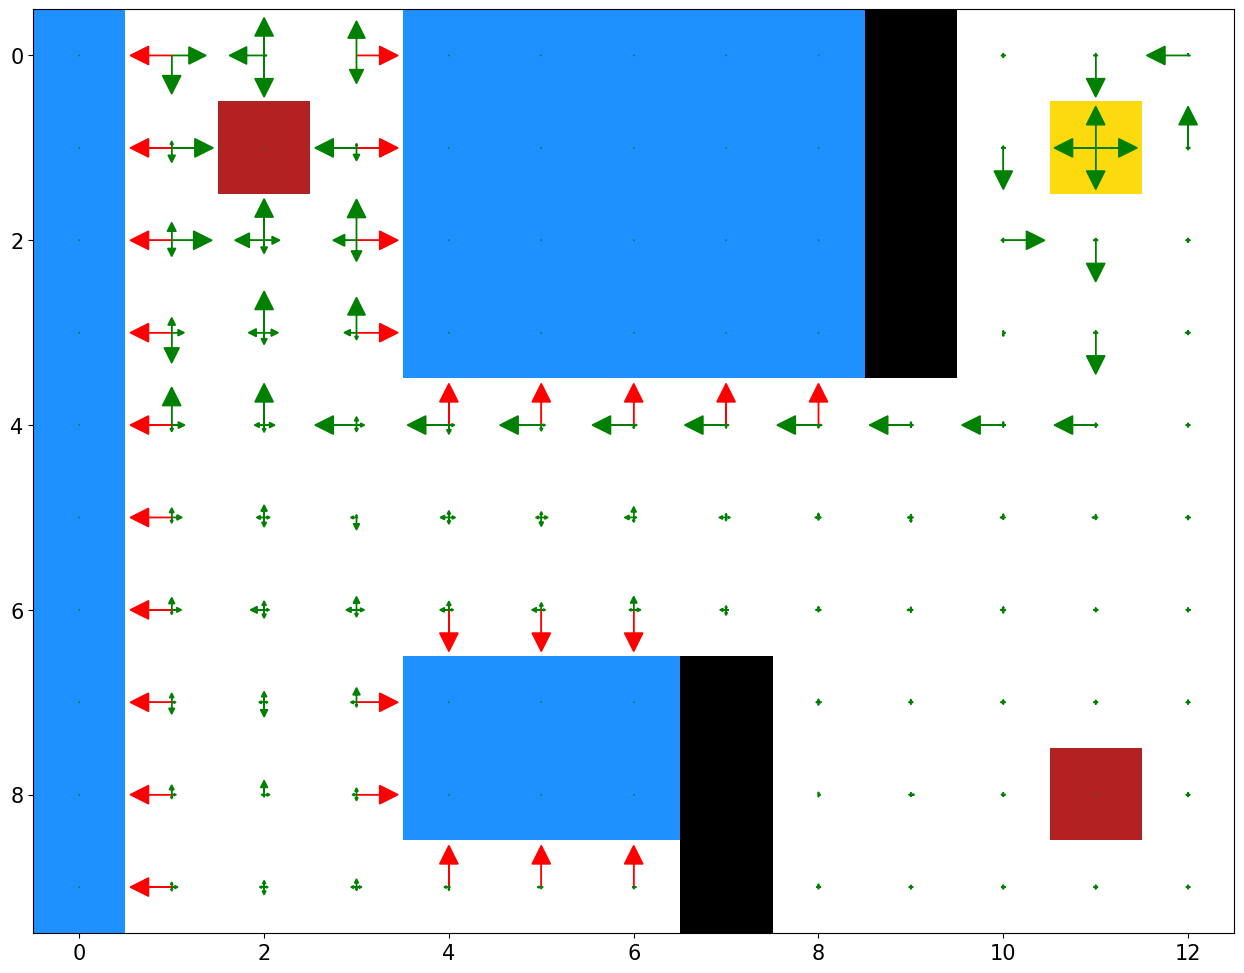

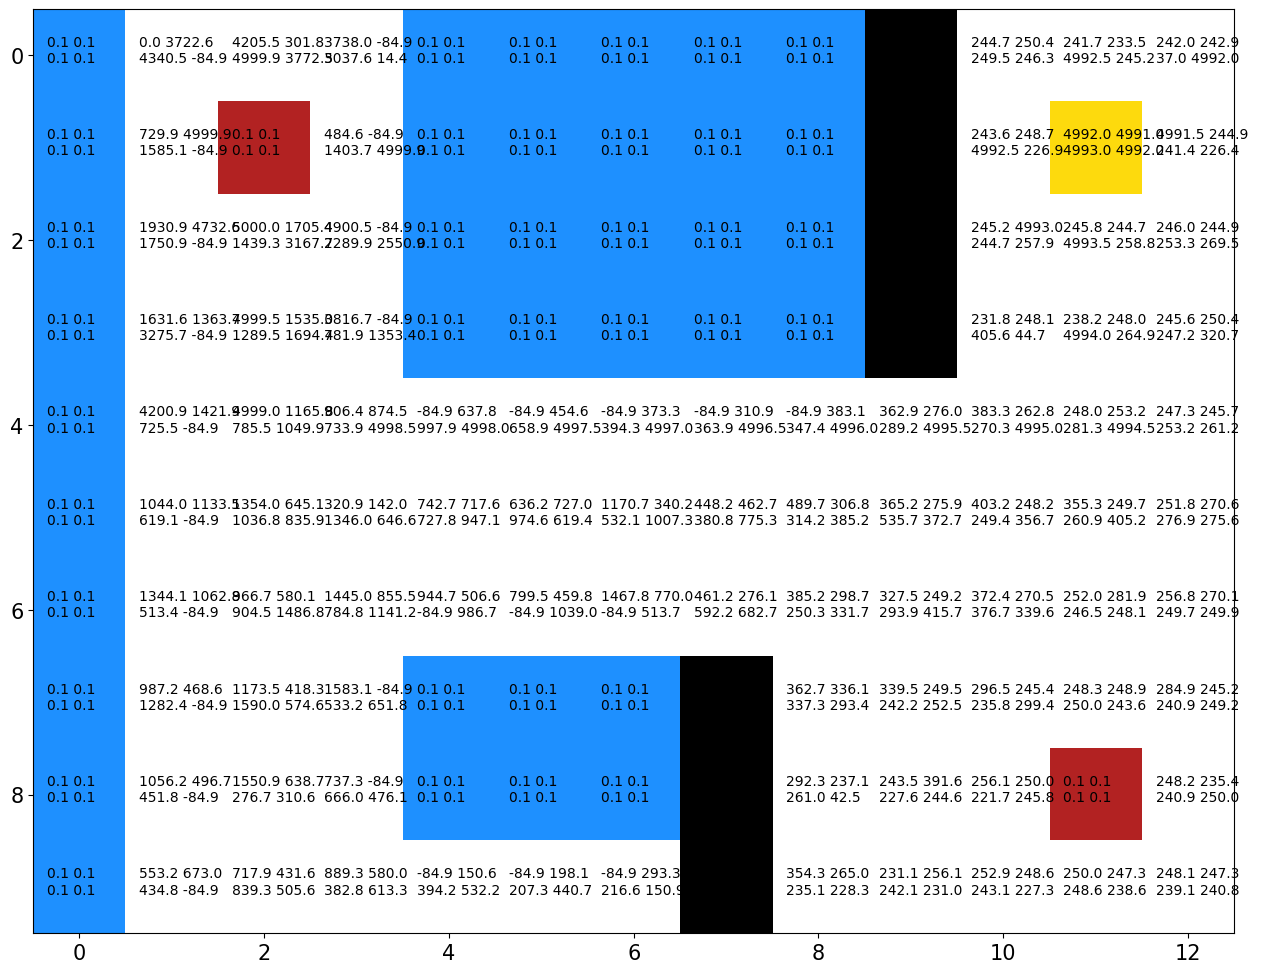

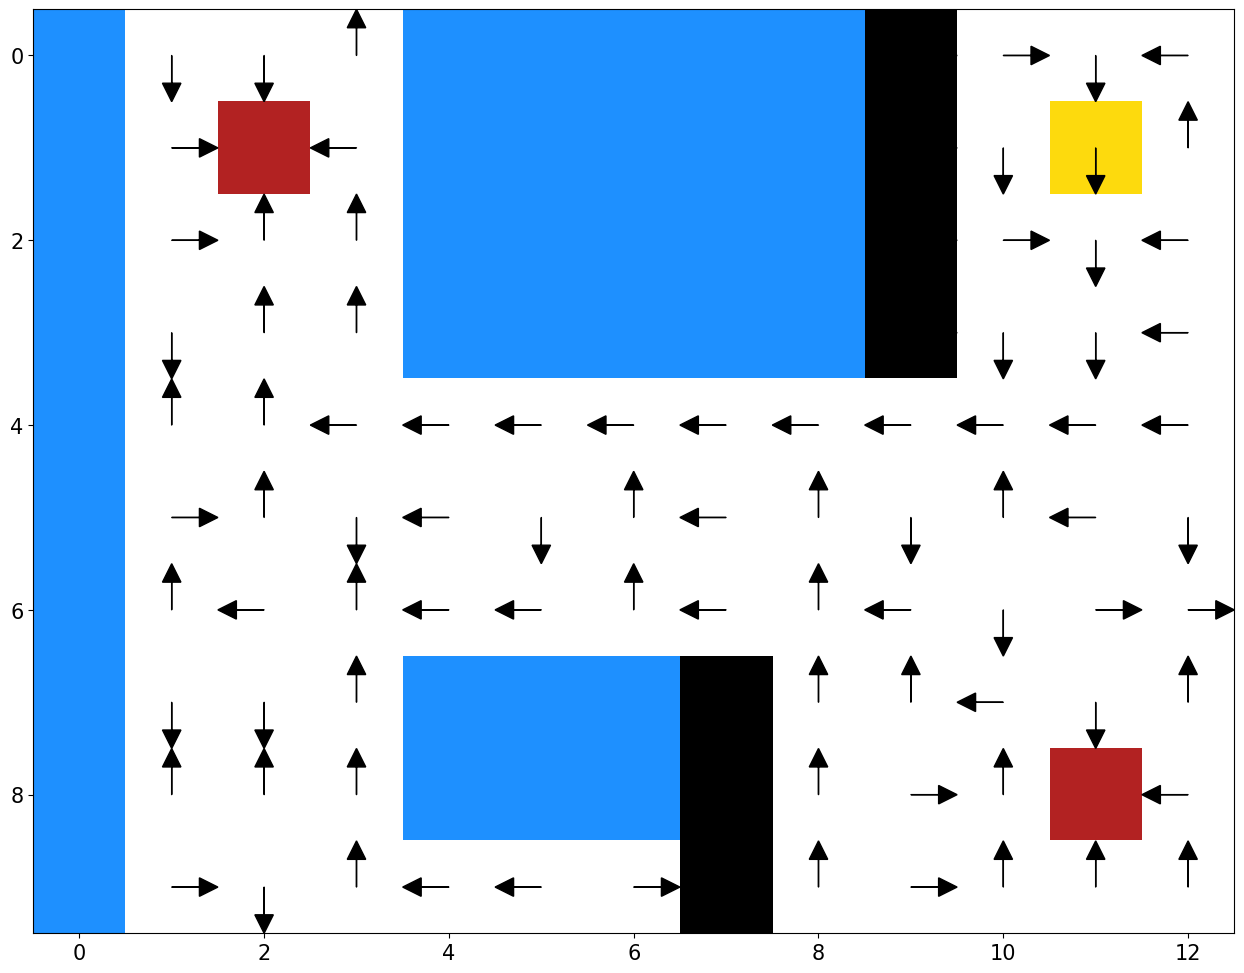

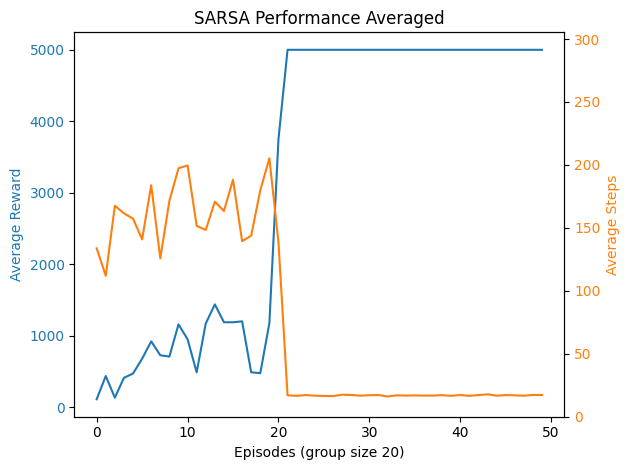

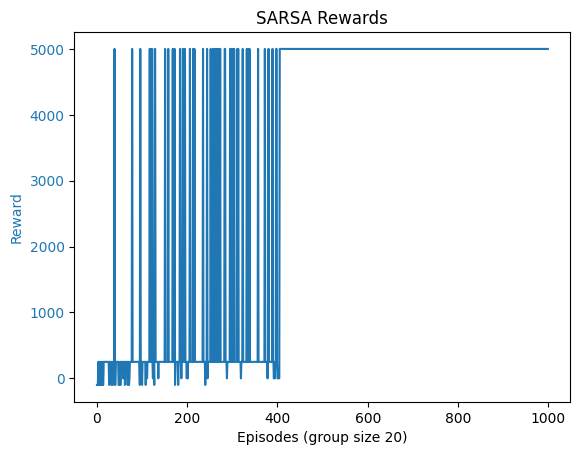

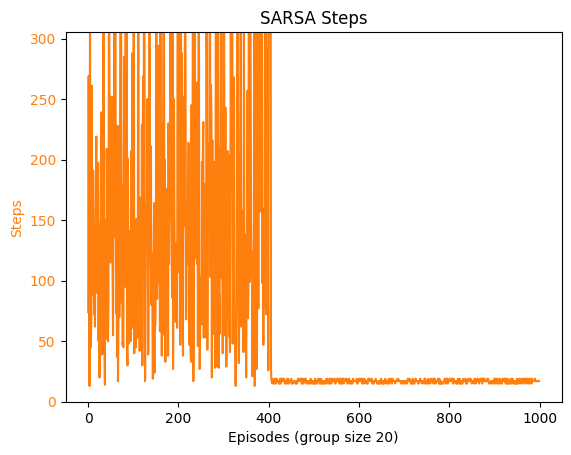

Rewards:
-100.0 27
0.0 20
250.0 311
5000.0 642
0 | 0.0s left (600 steps) | [ 83886080.0 steps / s ]      [0.0s]
100 | 2.0s left (500 steps) | [ 187.44 steps / s ]      [0.0s]
200 | 2.0s left (400 steps) | [ 154.23 steps / s ]      [1.0s]
300 | 1.0s left (300 steps) | [ 150.03 steps / s ]      [1.0s]
400 | 1.0s left (200 steps) | [ 152.04 steps / s ]      [2.0s]
500 | 0.0s left (100 steps) | [ 1164.72 steps / s ]      [2.0s]
20000.0 -339.94
len(neg): 26, neg[-1]: -84.985


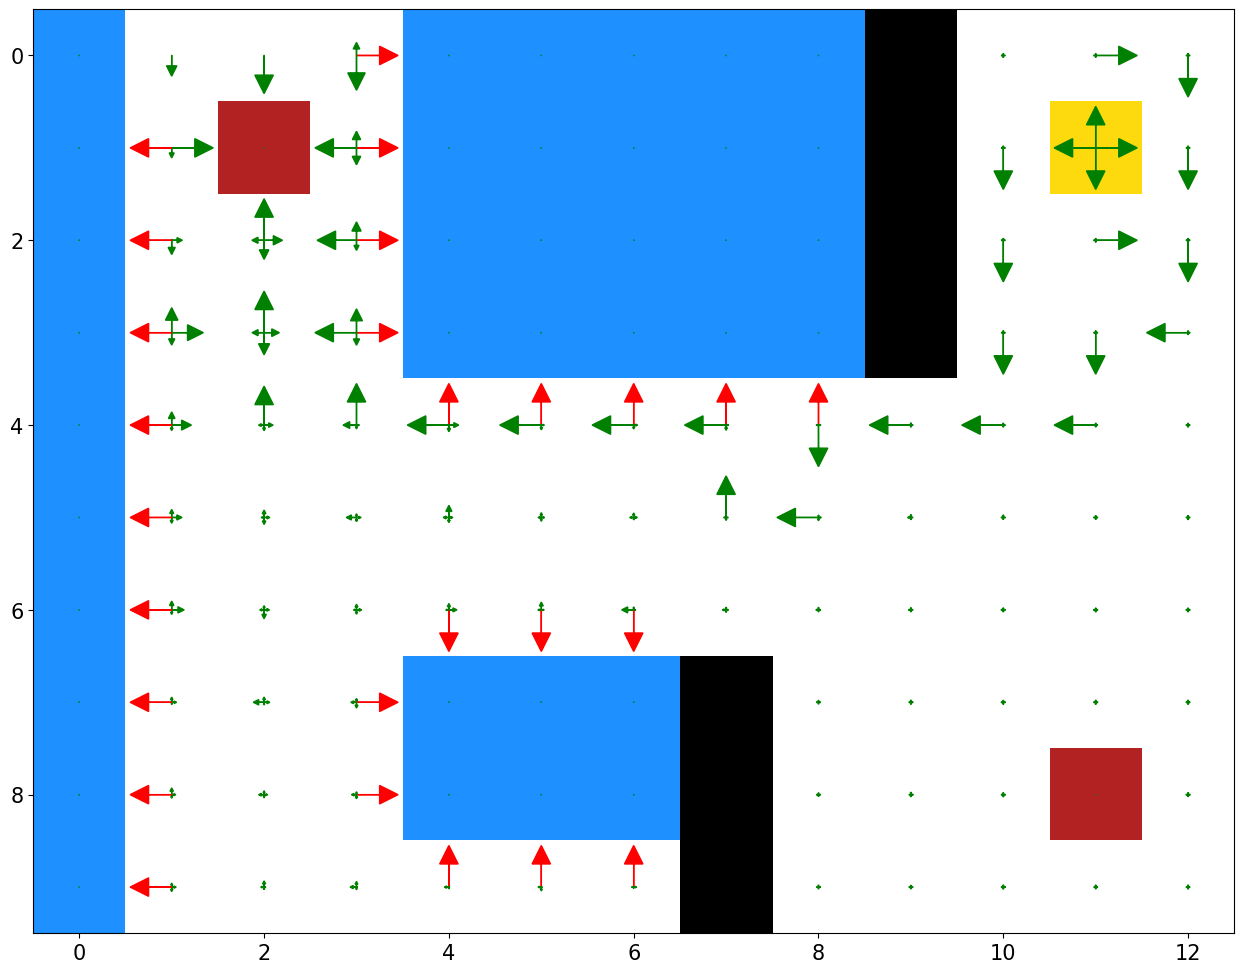

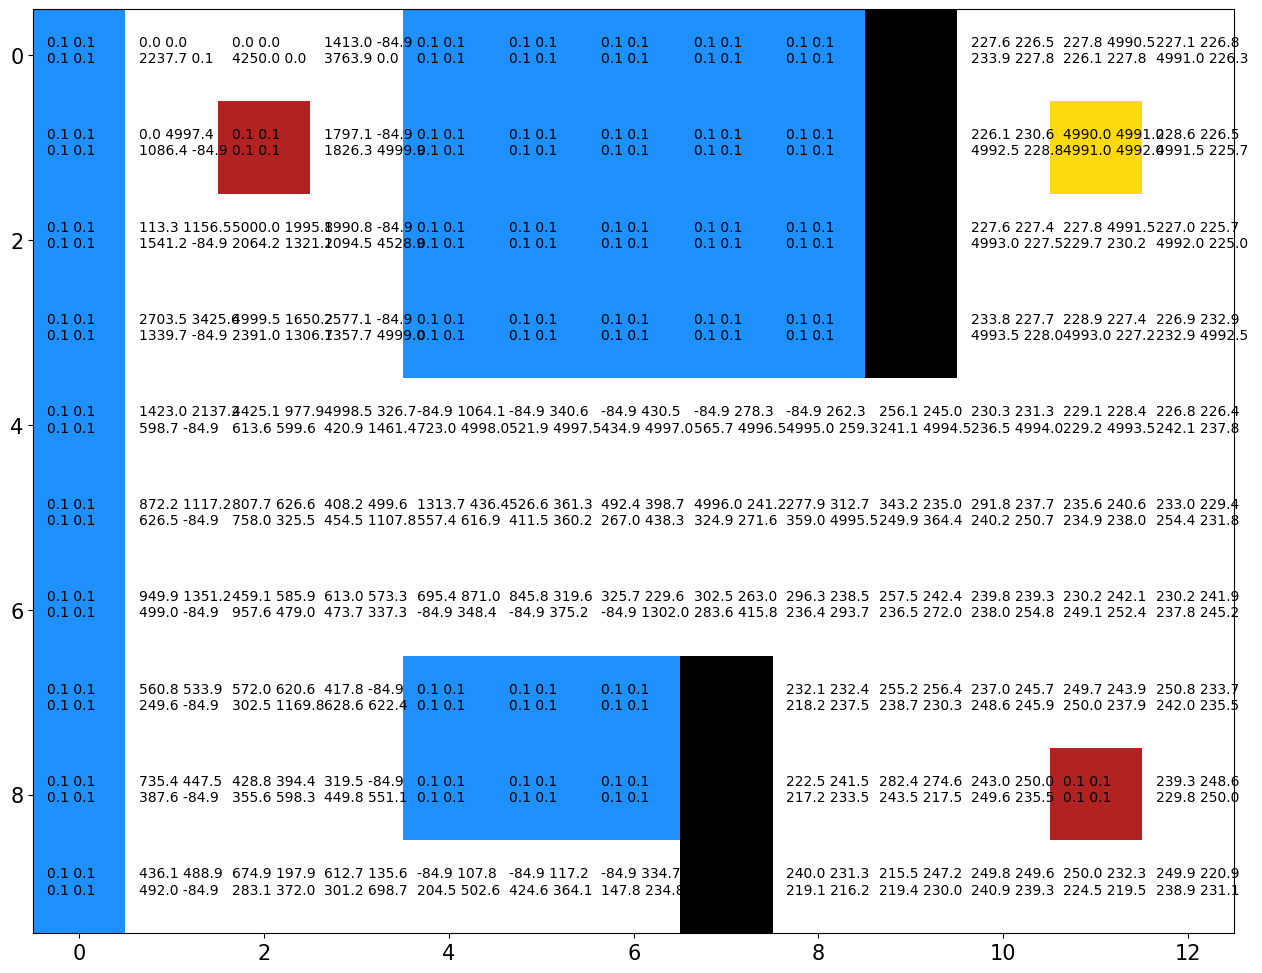

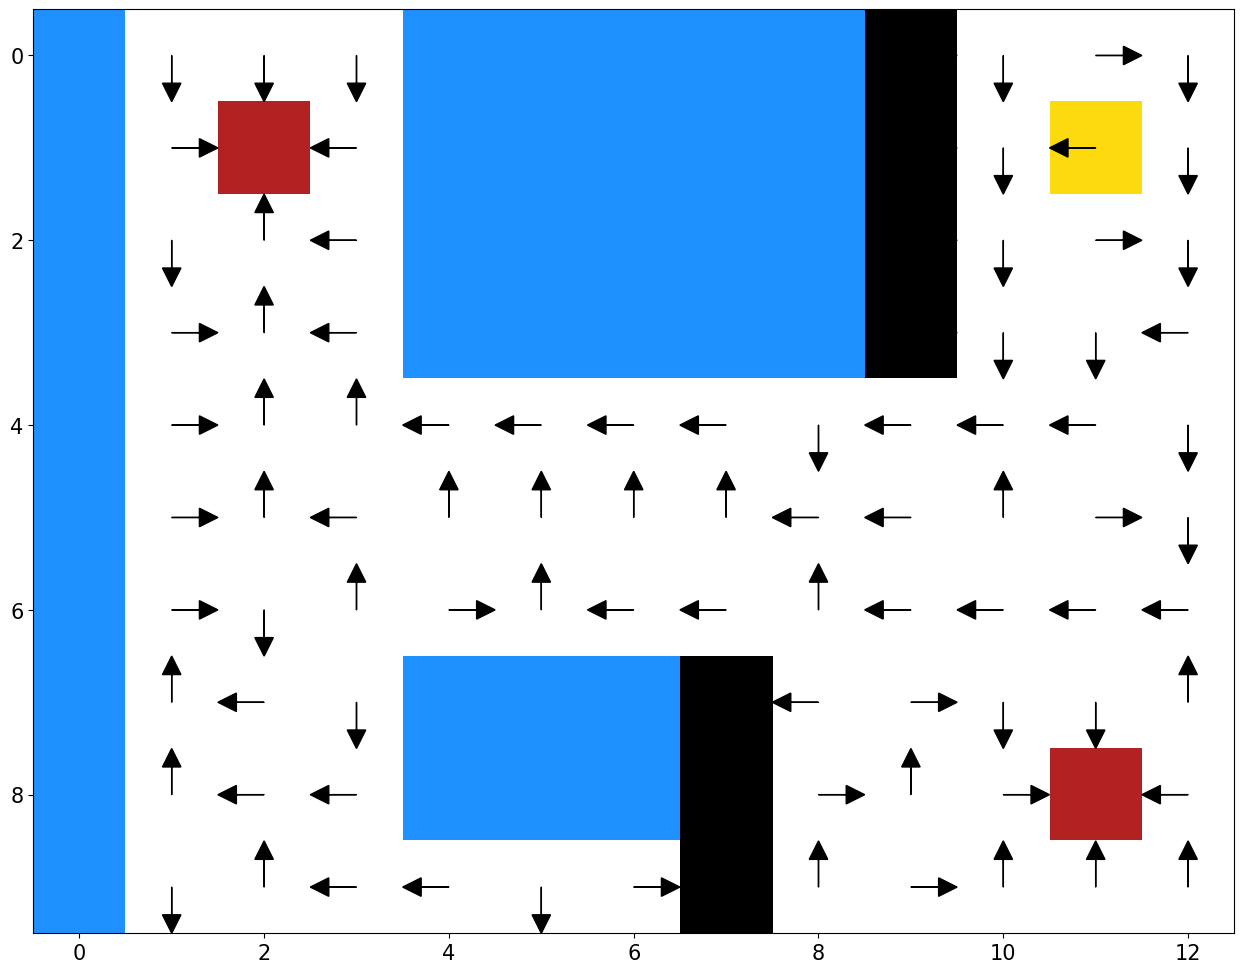

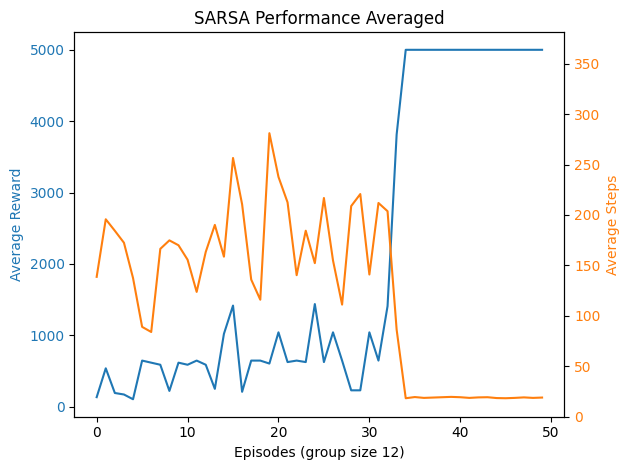

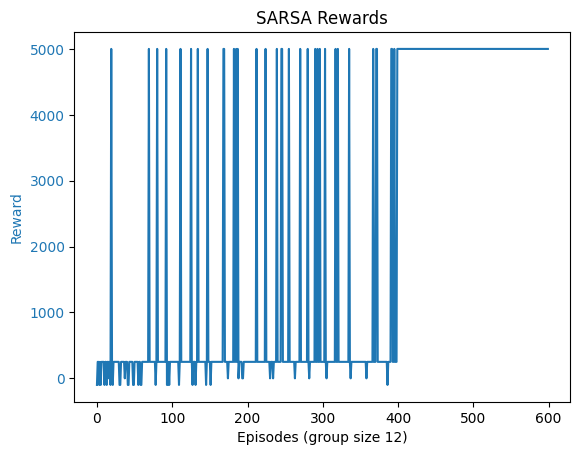

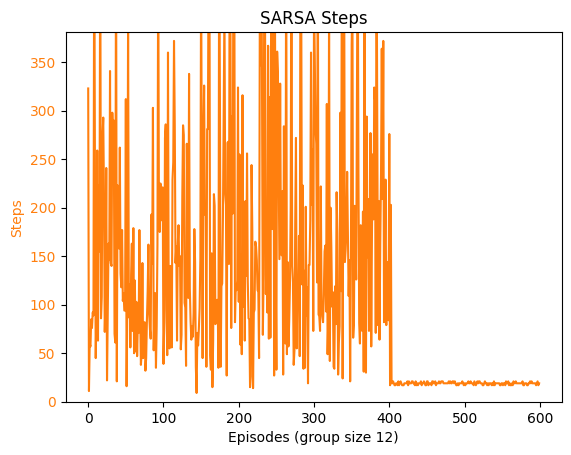

Rewards:
-100.0 26
0.0 13
250.0 326
5000.0 235


In [420]:
 # Sersa  algorithm with epsilon greedy and epsilon greedy safe
def epsilon_greedy(state, Q, epsilon, deterministic = False):
    if np.random.random() < epsilon:
      # explore randomly
      return np.random.randint(0, 4)
    else:
      # take greedy action
      best_reward = np.max(Q[state])
      best_actions = np.flatnonzero(Q[state] == best_reward)
      if deterministic:
        return best_actions[0]
      return np.random.choice(best_actions)

def epsilon_greedy_safe(state, Q, epsilon, deterministic = False): # Only takes negative random option if absolutely necessary
    if np.random.random() < epsilon:
        # explore randomly, safely
        values = Q[state]
        if np.max(values) < 0:
            return np.random.randint(0, 4)
        safe_actions = np.flatnonzero(values >= 0)
        return np.random.choice(safe_actions)
    else:
      # take greedy action
      best_reward = np.max(Q[state])
      best_actions = np.flatnonzero(Q[state] == best_reward)
      if deterministic:
        return best_actions[0]
      return np.random.choice(best_actions)

def learn_policy_sarsa(env: GridWorld, 
                       n_episodes: int=1, 
                       eta=0.1, 
                       gamma=0.1, 
                       stage_2_time=1500, 
                       stage_2_rate=0.1
                      ) -> tuple[np.ndarray, list[float], list[int]]:
    """
    Solve a given GridWorld environment using SARSA or Q-learning

    Args:
        env: The grid-world environment that will return states and rewards when given actions.
        n_episodes: Number of episodes for which to run learning.

    Returns:
        policy: A 2D array that represents the best action to take from each state location.
        total_rewards: Corresponding list of successive total non-discounted sum of reward for each trial
        episode_lengths: Corresponding list of episode lengths.
    """

    ####
    # Add your code here
    # WARNING: this agent should only access env.reset() and env.step()
    ####
    debug = 0
    feedback_steps = 100
    Q = np.ones((env.get_state_size(), 4)) * 0.1
    total_rewards = []
    episode_lengths = []
    most_recent_action_from_state = np.ones(env.get_gridshape()) * -1
    then = time.time()
    start_time = then
    for episode in range(n_episodes):
        if (episode % feedback_steps == 0):
            now = time.time()
            dt = now - then
            remaining = (n_episodes - episode)
            speed = feedback_steps / dt
            est = remaining / speed
            print(f"{episode} | {np.trunc(est)}s left ({remaining} steps) | [ {np.trunc(100*speed)/100} steps / s ]      [{np.trunc(now - start_time)}s]")
            then = time.time()
        greedy_actions = np.ones(env.get_gridshape())
        _, state, reward, done = env.reset()
        action = epsilon_greedy_safe(state, Q, 1)
        total_rewards.append(0)
        episode_lengths.append(0)
        while not done:
            _, new_state, reward, done = env.step(action)
            epsilon = epsilon_f(episode, stage_2_time, stage_2_rate)
            if  _ % 25 == 0 and debug < 0:
                print(epsilon, _)
                debug += 1
            banned_action = (action + 2) % 4
            
            total_rewards[episode] += reward
            episode_lengths[episode] += 1
            state_as_tuple = env.get_loc_from_state(state)
            most_recent_action_from_state[*state_as_tuple] = action
            new_action = epsilon_greedy_safe(new_state, Q, epsilon)
            if (done):
                delta = reward - Q[state][action]
            else:
                delta = reward + gamma*Q[new_state][new_action] - Q[state][action]
            Q[state][action] += eta * delta
            state = new_state
            action = new_action
    for state in range(len(Q)):
        i,j = env.get_loc_from_state(state)
        greedy_actions[i][j] = epsilon_greedy_safe(state, Q, -1, True) if most_recent_action_from_state[i][j] != -1 else -1
    

    policy = greedy_actions




    return policy, total_rewards, episode_lengths, Q


def epsilon_f(_, stage_2_time, stage_2_rate):
    return 1 if _ < stage_2_time else stage_2_rate


def train(env, n_episodes, eta, gamma, stage_2_time, stage_2_rate):
    policy, total_rewards, total_steps, Q = learn_policy_sarsa(env,
                                                          n_episodes,
                                                          eta,
                                                          gamma,
                                                          stage_2_time, 
                                                          stage_2_rate
                                                           )
    # Plotting
    draw_grid_Q_arrows(env, Q)
    draw_grid_text(env, Q)
    paint_gridworld(env, actions=policy)
    plot_rewards_and_steps(total_rewards, total_steps)
    values, counts = np.unique(total_rewards, return_counts=True)
    rewards_occurences = dict(zip(values, counts))
    values, counts = np.unique(total_steps, return_counts=True)
    steps_occurences = dict(zip(values, counts))
    print("Rewards:")
    for v in rewards_occurences:
        print(v, rewards_occurences[v])


env2 = GridWorld(goal_locations=[(1,2), (8,11)], goal_rewards=[5000, 250])
"""
# plot 8
train(env2,
        n_episodes = 5000,
        eta= 0.95,
        gamma = 1 - 0.01,
       stage_2_time=200, 
       stage_2_rate=0.1
     )

# plot 9
train(env2,
        n_episodes = 5000,
        eta= 0.95,
        gamma = 1 - 0.01,
       stage_2_time=1000, 
       stage_2_rate=0.1
     )

# plot 10
train(env2,
        n_episodes = 5000,
        eta= 0.5,
        gamma = 1 - 0.01,
       stage_2_time=1000, 
       stage_2_rate=0
     )"""

t = 400
n = 2000
e = 0.85
train(env2,
        n_episodes = 2000,
        eta= e,
        gamma = 1 - 0.0001,
       stage_2_time=t, 
       stage_2_rate=0
     )

train(env2,
        n_episodes = 1000,
        eta= e,
        gamma = 1 - 0.0001,
       stage_2_time=t, 
       stage_2_rate=0
     )

train(env2,
        n_episodes = 600,
        eta= 0.85,
        gamma = 1 - 0.0001,
       stage_2_time=400, 
       stage_2_rate=0
     )